# PSM-XGBoost

To solve the problem of endogeneity, use propensity score matching (PSM) combined with XGBoost to analyze the Internet usage

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import shap
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier, XGBRegressor

## Load and Make Datasets

In [4]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [5]:
Df = pd.read_parquet(Df_Filename)

In [6]:
Df.shape

(798604, 74)

In [7]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [8]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

### One-hot & Shuffle Conversion

In [9]:
print(Df['COUNTRY_ISO3'].dtype)

object


In [10]:
# 对 COUNTRY_ISO3 进行 one-hot 编码
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
country_encoded = onehot_encoder.fit_transform(Df[['COUNTRY_ISO3']])
country_columns = onehot_encoder.get_feature_names_out(['COUNTRY_ISO3'])

In [11]:
# 创建一个新的 DataFrame，包含 one-hot 编码后的国家列
country_df = pd.DataFrame(country_encoded, columns=country_columns, index=Df.index)

In [12]:
Df_new = pd.concat([Df.drop('COUNTRY_ISO3', axis=1), country_df], axis=1)

In [13]:
Df_new = Df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
Df_new.shape

(798604, 224)

In [15]:
Df_new.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,COUNTRY_ISO3_USA,COUNTRY_ISO3_UZB,COUNTRY_ISO3_VEN,COUNTRY_ISO3_VNM,COUNTRY_ISO3_XKX,COUNTRY_ISO3_XNC,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE
0,13,5278.624306,3.0,1.0,1.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,14,0.000000,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,5345.822529,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,17,10127.215850,5.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,16,7106.753699,6.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## Propensity Score Matching (XGBClassifier)

### 1. Data preprocessing: removing specific features

In [16]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 
                      'Sadness', 'Home_handline', 'Mobile_phone', 'Stress', 'Anger', 'Donated', 'Volunteer', 'Help_stranger',
                     'Religion_importance', 'Children_respected', 'Women_respected']
Df_new = Df_new.drop(columns=features_to_remove)

In [17]:
Df_new.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Living_standard_trend', 'Enough_food', 'Enough_shelter', 'Well_rested',
       'Respected',
       ...
       'COUNTRY_ISO3_USA', 'COUNTRY_ISO3_UZB', 'COUNTRY_ISO3_VEN',
       'COUNTRY_ISO3_VNM', 'COUNTRY_ISO3_XKX', 'COUNTRY_ISO3_XNC',
       'COUNTRY_ISO3_YEM', 'COUNTRY_ISO3_ZAF', 'COUNTRY_ISO3_ZMB',
       'COUNTRY_ISO3_ZWE'],
      dtype='object', length=207)

### 2. Prepare data

In [18]:
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 3. Optimization parameters

In [20]:
class RandomRunNFoldsKFold(KFold):
    def __init__(self, n_splits=10, random_state=None, run_splits=3, **kwargs):
        super().__init__(n_splits=n_splits, shuffle=True, random_state=random_state, **kwargs)
        self.random_state = random_state
        self.actual_splits = run_splits  # Number of actual splits to use

    def split(self, X, y=None, groups=None):
        folds = list(super().split(X, y, groups))
        if self.random_state is not None:
            random.seed(self.random_state)
        selected_folds = random.sample(folds, self.actual_splits)
        for train_index, test_index in selected_folds:
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.actual_splits

In [21]:
rkfcv = RandomRunNFoldsKFold(n_splits=10, run_splits=3, random_state=42)

In [22]:
def optimize_xgb_params(X_train, y_train):
    param_space = {
        'n_estimators': Integer(100, 5000),
        'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
        'max_depth': Integer(3, 16),
        'subsample': Real(0.5, 1.0),
        'min_child_weight': Real(0.001, 10, prior='log-uniform'),
        'max_delta_step': Real(0.001, 10, prior='log-uniform'),
        'reg_lambda': Real(0.001, 10, prior='log-uniform'),
        'reg_alpha': Real(0.001, 10, prior='log-uniform'),
        'gamma': Real(0.001, 10, prior='log-uniform')
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic', device='cuda', tree_method='hist', random_state=42)
    
    bayes_search = BayesSearchCV(
        estimator=xgb_model,
        search_spaces=param_space,
        n_iter=50,  
        cv=rkfcv,
        scoring='roc_auc',
        n_jobs=1,
        verbose=2,
        random_state=42
    )
    
    bayes_search.fit(X_train, y_train)
    
    print("Best parameters:", bayes_search.best_params_)
    print("Best ROC AUC score:", bayes_search.best_score_)
    
    return bayes_search.best_estimator_

best_model = optimize_xgb_params(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:14:08] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  55.0s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  56.5s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  57.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END gamma=2.2364202820542705, learning_rate=0.05842928269761146, max_delta_

Best parameters: OrderedDict([('gamma', 1.3107208727657829), ('learning_rate', 0.013247828257302013), ('max_delta_step', 2.4319470827525516), ('max_depth', 10), ('min_child_weight', 0.004050220338728457), ('n_estimators', 4921), ('reg_alpha', 0.0052168378523383165), ('reg_lambda', 0.011245420370413166), ('subsample', 0.7821067338698289)])
Best ROC AUC score: 0.9156261383615436
Test Accuracy: 0.8445
Test ROC AUC: 0.9146

### 4. Evaluate the best model

In [23]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8445
Test ROC AUC: 0.9146


### 5. Estimating propensity scores

In [24]:
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

### 6. Print propensity score statistics

In [25]:
print("\nPropensity Score Statistics:")
print(Df_new['propensity_score'].describe())

print("\nPropensity Score Statistics for Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'].describe())

print("\nPropensity Score Statistics for No Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'].describe())


Propensity Score Statistics:
count    798604.000000
mean          0.676141
std           0.345986
min           0.000990
25%           0.362205
50%           0.846415
75%           0.977225
max           0.999918
Name: propensity_score, dtype: float64

Propensity Score Statistics for Internet Access Group:
count    539754.000000
mean          0.875951
std           0.170088
min           0.007409
25%           0.830953
50%           0.952923
75%           0.988941
max           0.999918
Name: propensity_score, dtype: float64

Propensity Score Statistics for No Internet Access Group:
count    258850.000000
mean          0.259499
std           0.228372
min           0.000990
25%           0.074261
50%           0.186106
75%           0.391931
max           0.999649
Name: propensity_score, dtype: float64


### 6. Visualizing Propensity Score Distribution

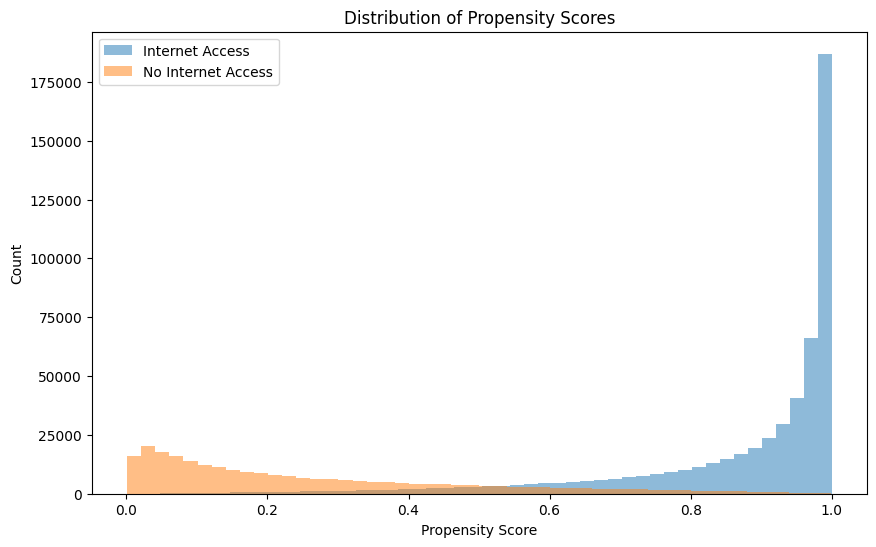

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()

### 7. Optimized sample matching function

In [27]:
from sklearn.neighbors import BallTree

Total matched pairs: 109915
Unique control samples used: 109915

Distribution of control sample usage:
1    109915
Name: count, dtype: int64


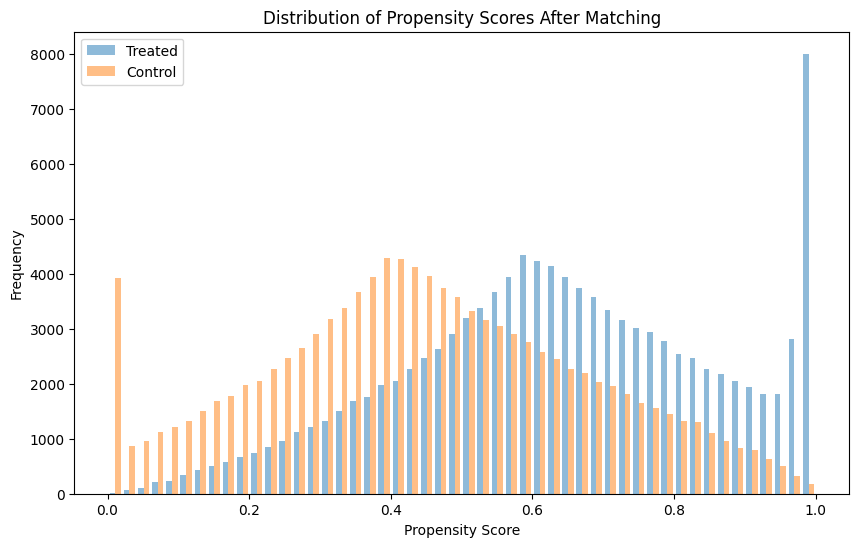

In [40]:
def match_samples_many_to_one_efficient(df, caliper=0.2, max_matches=1, n_jobs=-1, batch_size=10000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用BallTree进行高效的近邻搜索
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    # 批处理
    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        
        # 找到半径内的所有邻居
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break  # 找到匹配后跳出内循环

    # 创建匹配后的数据框
    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    # 统计信息
    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    # 可视化匹配质量
    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

# 使用函数
matched_df = match_samples_many_to_one_efficient(Df_new)

In [41]:
# 输出匹配后的样本数
print(f"\nFinal matched sample size: {len(matched_df)}")


Final matched sample size: 219830


In [42]:
matched_treated_count = len(matched_df[matched_df['Internet_access_available'] == 0])
print(f"Number of Matched Treated Samples: {matched_treated_count}")

Number of Matched Treated Samples: 109915


In [43]:
matched_df = matched_df.sample(frac=1, random_state=42).reset_index(drop=True)

### 8. Balance test(Standardized Mean Differences)

In [44]:
# 平衡性检验函数
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

# 定义需要检验的变量
variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

# 计算匹配前的SMD
smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')

# 计算匹配后的SMD
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

# 将SMD结果输出为DataFrame
smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})

print(smd_df)

             Variable  SMD Before  SMD After
0                wave    0.333406   0.025085
1            INCOME_2    0.511280   0.049848
2      Cantril_ladder    0.521002   0.089531
3      Health_disable   -0.417950  -0.028259
4       Relative_have    0.397612   0.025466
..                ...         ...        ...
201  COUNTRY_ISO3_XNC    0.095724  -0.000532
202  COUNTRY_ISO3_YEM   -0.068147   0.000679
203  COUNTRY_ISO3_ZAF   -0.009811  -0.009108
204  COUNTRY_ISO3_ZMB   -0.061810   0.001409
205  COUNTRY_ISO3_ZWE   -0.051431  -0.002134

[206 rows x 3 columns]


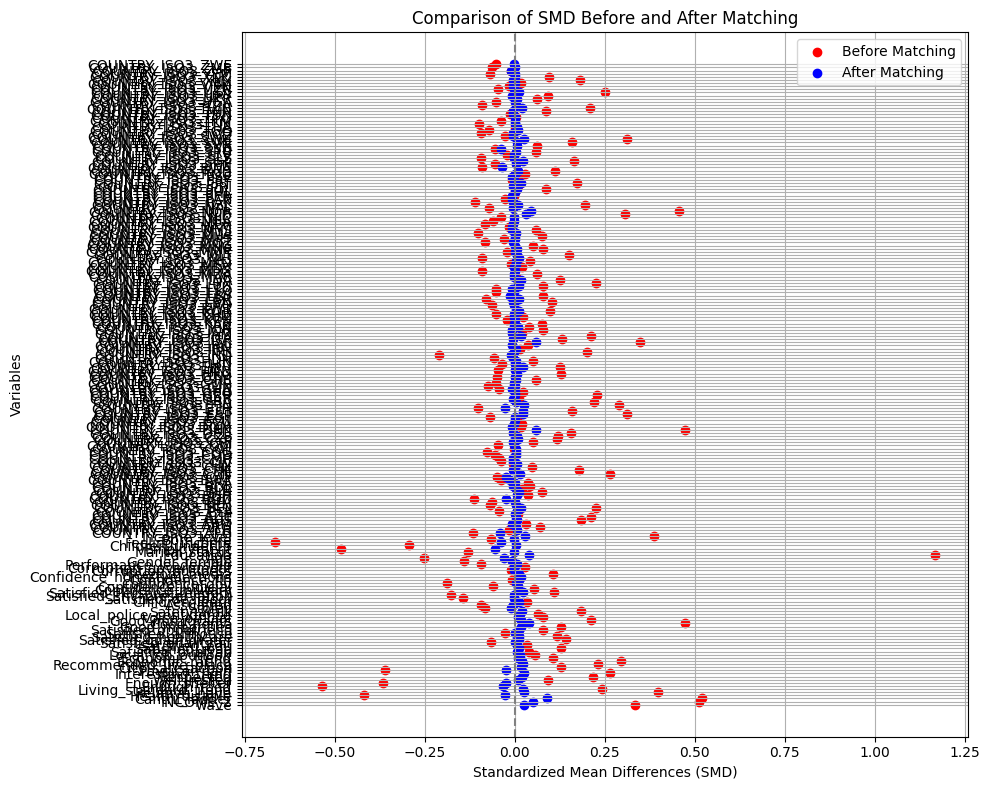

In [45]:
# 绘制匹配前后的SMD对比图
plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()

# 显示图表
plt.show()

In [78]:
matched_df.to_parquet(os.path.join('Data', 'PSM_matched.parquet'))

### 9. Group analysis

In [46]:
# 定义参数空间
param_space = {
    'n_estimators': Integer(100, 5000),
        'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
        'max_depth': Integer(3, 16),
        'subsample': Real(0.5, 1.0),
        'min_child_weight': Real(0.001, 10, prior='log-uniform'),
        'max_delta_step': Real(0.001, 10, prior='log-uniform'),
        'reg_lambda': Real(0.001, 10, prior='log-uniform'),
        'reg_alpha': Real(0.001, 10, prior='log-uniform'),
        'gamma': Real(0.001, 10, prior='log-uniform')
}

# 处理有互联网访问的组
treated = matched_df[matched_df['Internet_access_available'] == 1]
X_treated = treated.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
y_treated = treated['Cantril_ladder']

X_train_treated, X_test_treated, y_train_treated, y_test_treated = train_test_split(X_treated, y_treated, test_size=0.1, random_state=42)

# 初始化XGBoost模型（有互联网组）
xgb_model_treated = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', random_state=42)

# 使用BayesSearchCV进行参数优化（有互联网组）
bayes_search_treated = BayesSearchCV(
    estimator=xgb_model_treated,
    search_spaces=param_space,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 拟合模型（有互联网组）
bayes_search_treated.fit(X_train_treated, y_train_treated)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  15.8s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  15.4s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  15.5s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_del

BayesSearchCV(cv=10,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [47]:
# 打印最佳参数和交叉验证得分（有互联网组）
print("Best parameters for Internet Access group:", bayes_search_treated.best_params_)
print("Best cross-validation R-squared score for Internet Access group:", bayes_search_treated.best_score_)


Best parameters for Internet Access group: OrderedDict([('gamma', 10.0), ('learning_rate', 0.023427578505966756), ('max_delta_step', 0.5379354384473743), ('max_depth', 4), ('min_child_weight', 0.00106409010628778), ('n_estimators', 3381), ('reg_alpha', 0.001), ('reg_lambda', 10.0), ('subsample', 0.5)])
Best cross-validation R-squared score for Internet Access group: 0.25088801391935184


0.15 1
Best parameters for Internet Access group: OrderedDict([('gamma', 10.0), ('learning_rate', 0.01937702998294909), ('max_delta_step', 2.8614432589534116), ('max_depth', 3), ('min_child_weight', 0.001), ('n_estimators', 5000), ('reg_alpha', 10.0), ('reg_lambda', 0.14885954507248914), ('subsample', 0.6158337505909053)])
Best cross-validation R-squared score for Internet Access group: 0.24236979810823578
Best Train R-squared score for Internet Access group: 0.2836
Test R-squared score for Internet Access group: 0.2393


In [48]:
# 使用最佳模型进行预测（有互联网组）
best_model_treated = bayes_search_treated.best_estimator_

In [49]:
# 计算并打印最佳训练R²
y_train_pred_treated = best_model_treated.predict(X_train_treated)
r2_train_treated = r2_score(y_train_treated, y_train_pred_treated)
print(f"Best Train R-squared score for Internet Access group: {r2_train_treated:.4f}")

# 计算并打印测试集R²
y_test_pred_treated = best_model_treated.predict(X_test_treated)
r2_test_treated = r2_score(y_test_treated, y_test_pred_treated)
print(f"Test R-squared score for Internet Access group: {r2_test_treated:.4f}")

Best Train R-squared score for Internet Access group: 0.3001
Test R-squared score for Internet Access group: 0.2483


In [50]:
# 处理没有互联网访问的组（控制组）
control = matched_df[matched_df['Internet_access_available'] == 0]
control_unique = control.drop_duplicates(subset=control.columns.drop('propensity_score'))
X_control = control_unique.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
y_control = control_unique['Cantril_ladder']

X_train_control, X_test_control, y_train_control, y_test_control = train_test_split(X_control, y_control, test_size=0.1, random_state=42)

In [51]:
# 初始化XGBoost模型（无互联网组）
xgb_model_control = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', random_state=42)

# 使用BayesSearchCV进行参数优化（无互联网组）
bayes_search_control = BayesSearchCV(
    estimator=xgb_model_control,
    search_spaces=param_space,
    n_iter=50,
    cv=10,
    scoring='r2',
    n_jobs=1,
    verbose=2,
    random_state=42
)

# 拟合模型（无互联网组）
bayes_search_control.fit(X_train_control, y_train_control)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  14.9s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  14.8s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_delta_step=5.388550972627239, max_depth=7, min_child_weight=0.47928274405969296, n_estimators=2129, reg_alpha=0.025335258486348353, reg_lambda=0.9078559343576645, subsample=0.6522316555182531; total time=  14.9s
[CV] END gamma=0.04369339947510315, learning_rate=0.02853983686604182, max_del

BayesSearchCV(cv=10,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=No...
                             'min_child_weight': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=5000, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'reg_lambda': Real(low=0.001, high=10, prior='log-uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')},
              verbose=2)

In [52]:
# 打印最佳参数和得分（无互联网组）
print("Best parameters for No Internet Access group:", bayes_search_control.best_params_)
print("Best R-squared score for No Internet Access group:", bayes_search_control.best_score_)

# 使用最佳模型进行预测（无互联网组）
best_model_control = bayes_search_control.best_estimator_
y_pred_control = best_model_control.predict(X_test_control)
r2_control = r2_score(y_test_control, y_pred_control)
print(f"Test R-squared score for No Internet Access group: {r2_control:.4f}")

# 计算训练集上的R方分数（无互联网组）
y_train_pred_control = best_model_control.predict(X_train_control)
r2_train_control = r2_score(y_train_control, y_train_pred_control)
print(f"Train R-squared score for No Internet Access group: {r2_train_control:.4f}")

Best parameters for No Internet Access group: OrderedDict([('gamma', 0.002113402522506742), ('learning_rate', 0.008081563837646945), ('max_delta_step', 1.1543314857691693), ('max_depth', 5), ('min_child_weight', 0.37389021634776615), ('n_estimators', 4837), ('reg_alpha', 0.001), ('reg_lambda', 0.0010944840586507066), ('subsample', 0.6302531856285355)])
Best R-squared score for No Internet Access group: 0.23825721115325224
Test R-squared score for No Internet Access group: 0.2266
Train R-squared score for No Internet Access group: 0.3057


0.15 1
Best parameters for No Internet Access group: OrderedDict([('gamma', 0.06935315940929113), ('learning_rate', 0.04920200166359325), ('max_delta_step', 0.05108616055537394), ('max_depth', 14), ('min_child_weight', 0.0034520800074582213), ('n_estimators', 1938), ('reg_alpha', 10.0), ('reg_lambda', 0.007157040930357397), ('subsample', 0.611652770272519)])
Best R-squared score for No Internet Access group: 0.23993801965939215
Test R-squared score for No Internet Access group: 0.2374
Train R-squared score for No Internet Access group: 0.3996



### 10. SHAP

In [53]:
# 步骤1：为有互联网访问组计算SHAP值
explainer_treated = shap.TreeExplainer(best_model_treated)
shap_values_treated = explainer_treated.shap_values(X_treated)

# 步骤2：为无互联网访问组计算SHAP值
explainer_control = shap.TreeExplainer(best_model_control)
shap_values_control = explainer_control.shap_values(X_control)

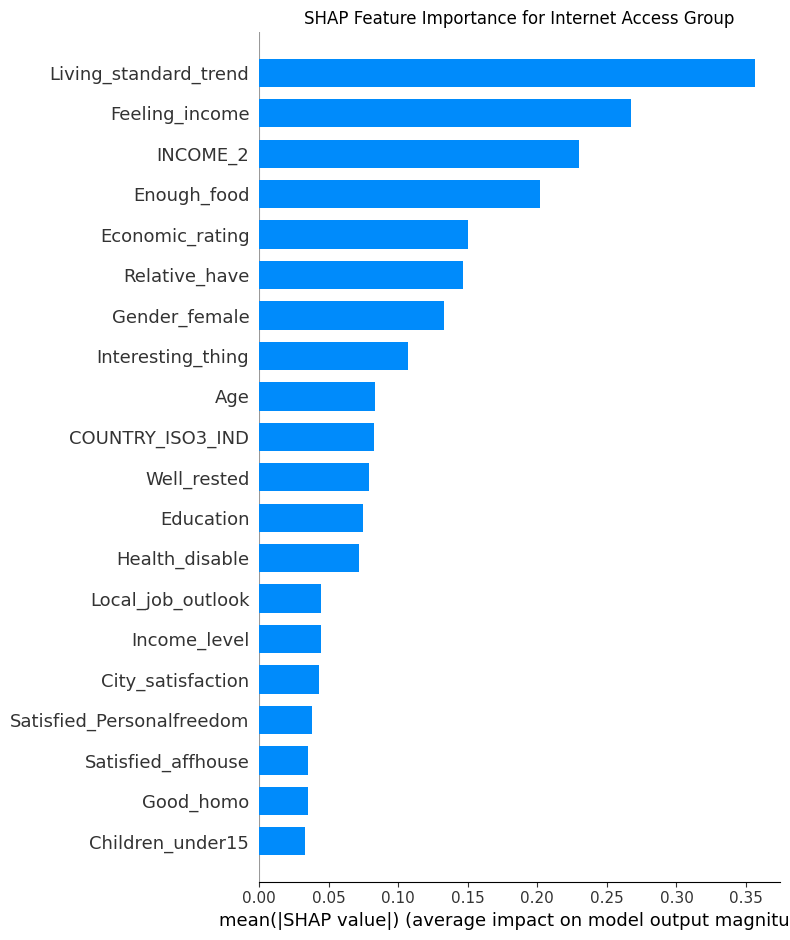

In [62]:
# 步骤3：绘制并显示有互联网访问组的特征重要性总结图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_treated, X_treated, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

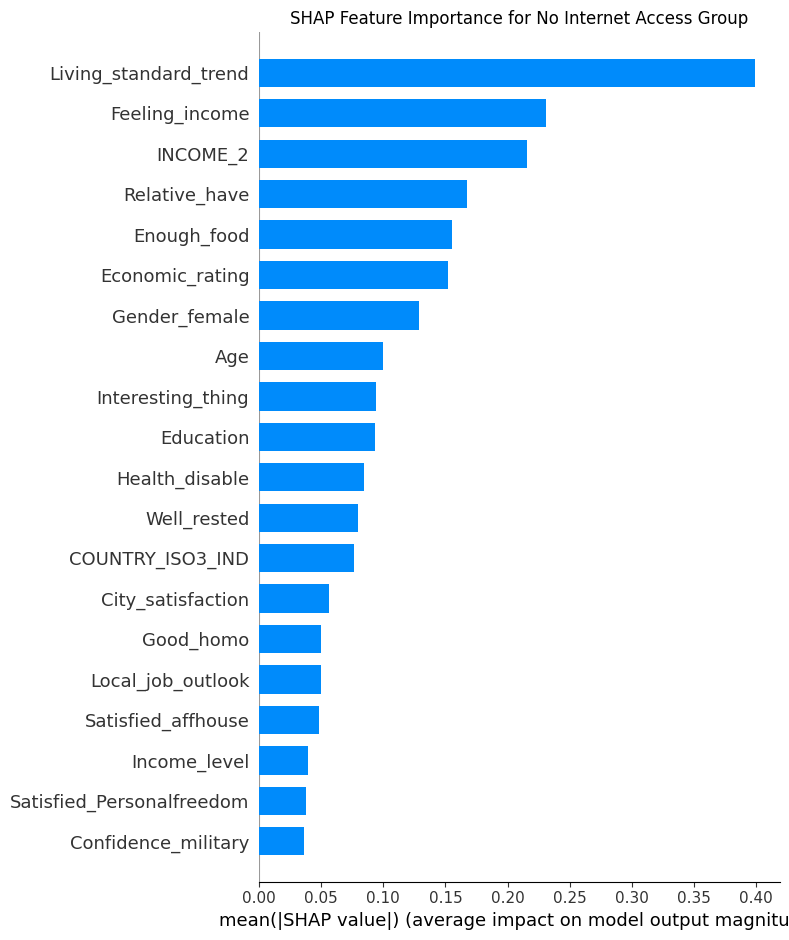

In [63]:
# 步骤4：绘制无互联网访问组的特征重要性总结图
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_control, X_control, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()

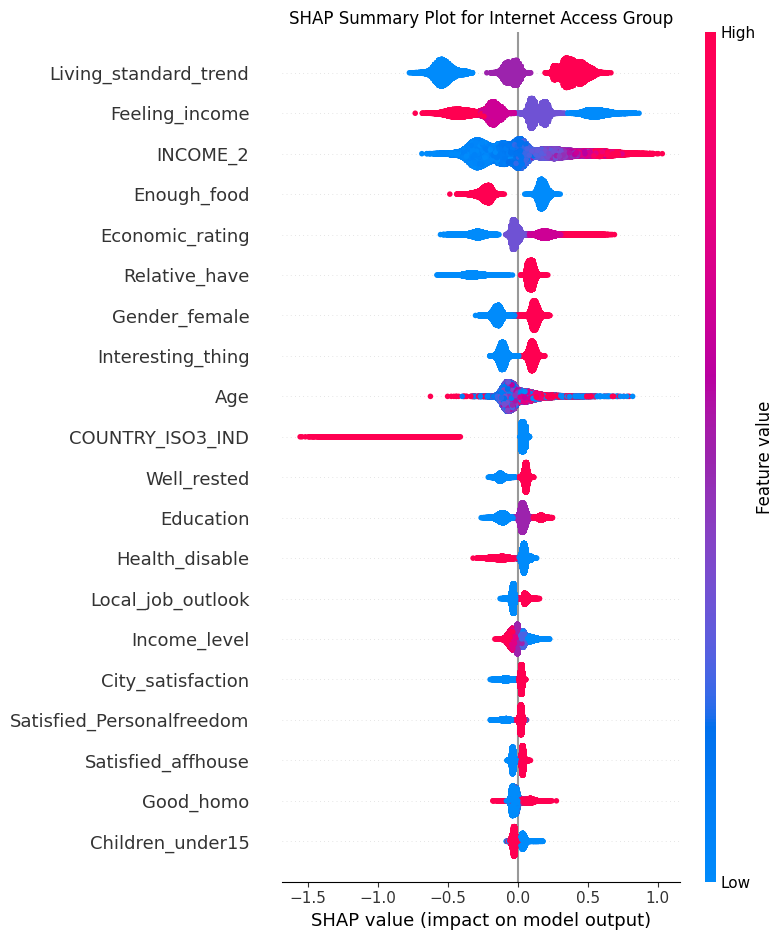

In [64]:
# 步骤5：绘制有互联网访问组的SHAP摘要图
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_treated, X_treated, show=False)
plt.title("SHAP Summary Plot for Internet Access Group")
plt.tight_layout()
plt.show()

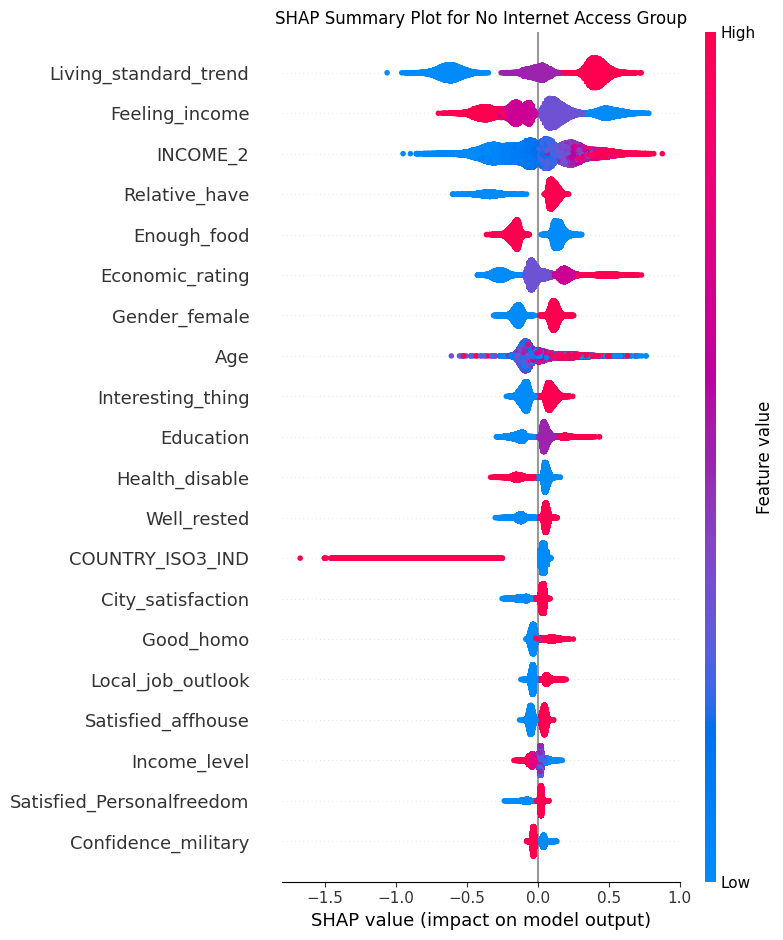

In [65]:
# 步骤6：绘制无互联网访问组的SHAP摘要图
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_control, X_control, show=False)
plt.title("SHAP Summary Plot for No Internet Access Group")
plt.tight_layout()
plt.show()

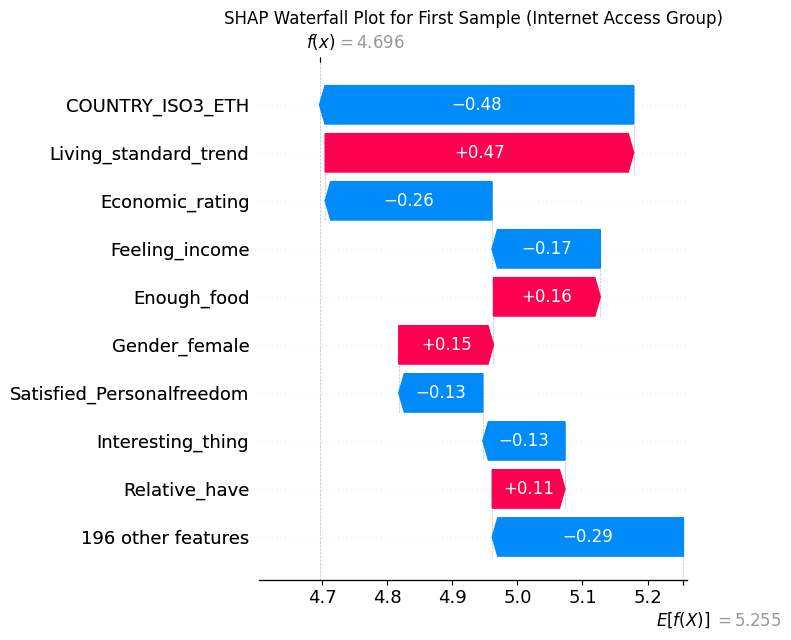

In [68]:
# 步骤11：绘制有互联网访问组的SHAP瀑布图（第一个样本）
plt.figure(figsize=(10, 12))
shap.plots._waterfall.waterfall_legacy(explainer_treated.expected_value, shap_values_treated[0], feature_names=X_treated.columns, show=False)
plt.title("SHAP Waterfall Plot for First Sample (Internet Access Group)")
plt.tight_layout()
plt.show()

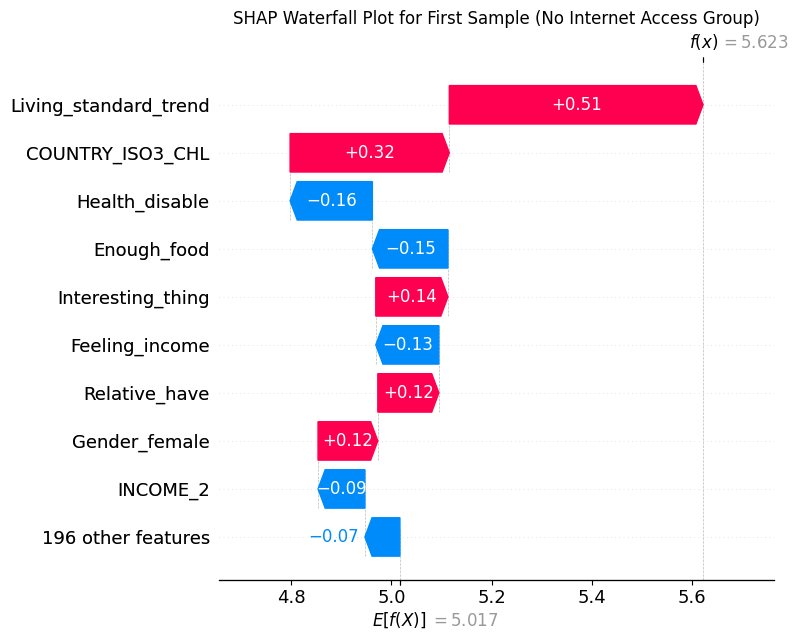

In [69]:
# 步骤12：绘制无互联网访问组的SHAP瀑布图（第一个样本）
plt.figure(figsize=(10, 12))
shap.plots._waterfall.waterfall_legacy(explainer_control.expected_value, shap_values_control[0], feature_names=X_control.columns, show=False)
plt.title("SHAP Waterfall Plot for First Sample (No Internet Access Group)")
plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

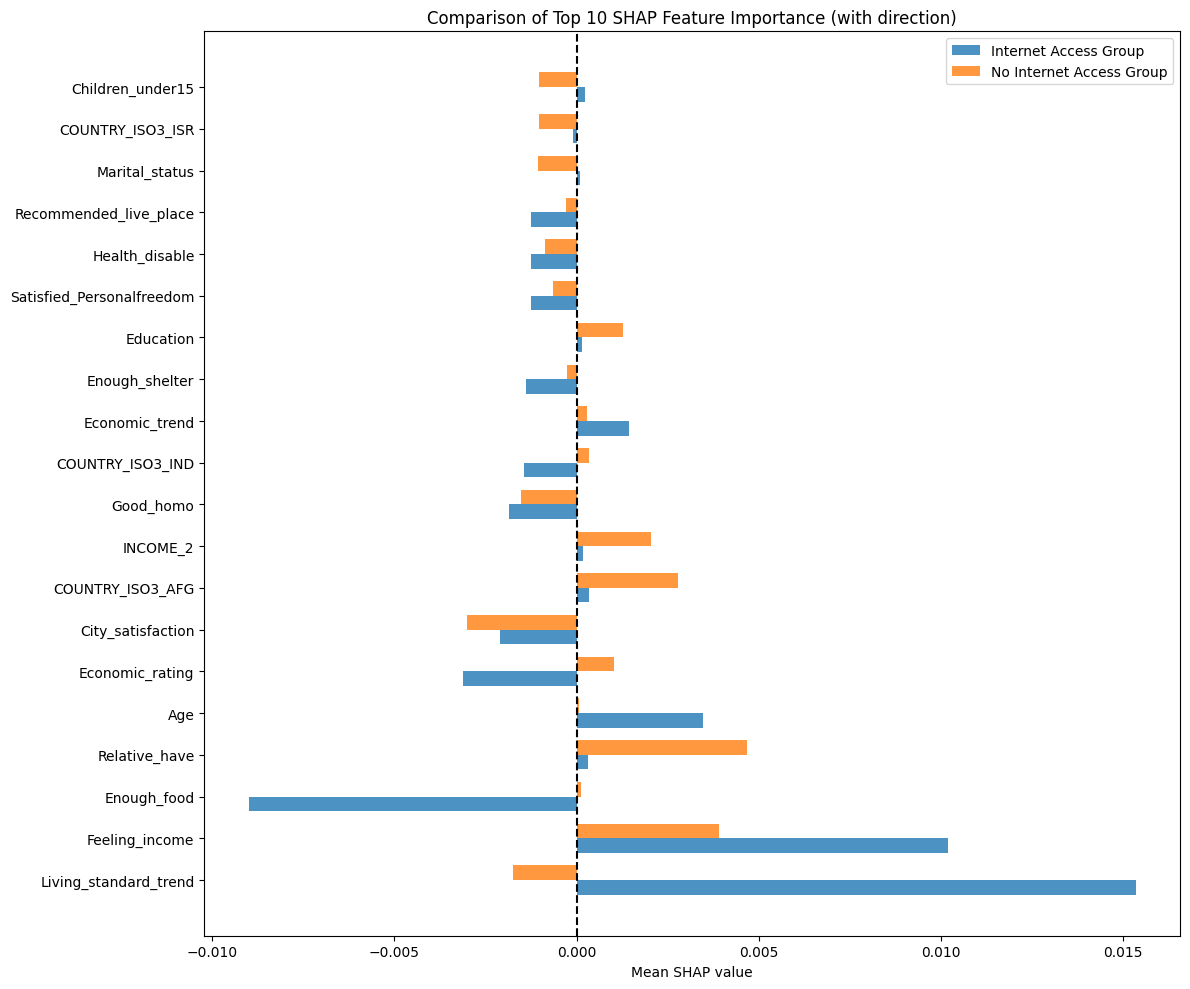

SHAP analysis completed. Top 10 features comparison plot with direction has been displayed.


In [125]:
# 步骤13：比较两组的SHAP值（显示前10个特征，保留正负方向）
plt.figure(figsize=(12, 10))

# 计算每个特征的平均 SHAP 值（不取绝对值）
shap_importance_treated = shap_values_treated.mean(axis=0)
shap_importance_control = shap_values_control.mean(axis=0)

# 获取所有特征名称
all_features = list(set(X_treated.columns) | set(X_control.columns))

# 创建一个字典来存储每个特征的重要性
importance_dict = {feature: [0, 0] for feature in all_features}

for feature, importance in zip(X_treated.columns, shap_importance_treated):
    importance_dict[feature][0] = importance

for feature, importance in zip(X_control.columns, shap_importance_control):
    importance_dict[feature][1] = importance

# 将字典转换为排序后的列表，并只保留前10个（基于绝对值的大小）
sorted_importance = sorted(importance_dict.items(), key=lambda x: max(abs(x[1][0]), abs(x[1][1])), reverse=True)[:20]

# 提取特征名称和重要性值
features = [item[0] for item in sorted_importance]
treated_importance = [item[1][0] for item in sorted_importance]
control_importance = [item[1][1] for item in sorted_importance]

# 创建条形图
y = range(len(features))
fig, ax = plt.subplots(figsize=(12, 10))

# 绘制水平条形图
ax.barh(y, treated_importance, height=0.35, label='Internet Access Group', alpha=0.8)
ax.barh([i + 0.35 for i in y], control_importance, height=0.35, label='No Internet Access Group', alpha=0.8)

# 添加标签和标题
ax.set_xlabel('Mean SHAP value')
ax.set_title('Comparison of Top 10 SHAP Feature Importance (with direction)')
ax.set_yticks([i + 0.175 for i in y])
ax.set_yticklabels(features)
ax.legend()

# 添加垂直线表示零点
ax.axvline(x=0, color='k', linestyle='--')

# 调整布局以确保所有标签都可见
plt.tight_layout()
plt.show()

print("SHAP analysis completed. Top 10 features comparison plot with direction has been displayed.")

### 11. Comparing variable effects

In [73]:
def compare_variable_impact(variable_name):
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(variable_name)]).mean()
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(variable_name)]).mean()
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {impact_with:.4f}")
    print(f"  Without Internet Access: {impact_without:.4f}")
    print(f"  Difference: {impact_with - impact_without:.4f}")

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',  # 经济前景
    'Satisfied_edu', 'Satisfied_healthcare',  # 教育和医疗满意度
    'Voice_official', 'Freedom_media',  # 公民参与和信息自由
    'Children_learn',   # 社会发展指标
    'Safety_walk', 'Confidence_judicial'  # 安全感和制度信心
]
for var in variables_of_interest:
    compare_variable_impact(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2302
  Without Internet Access: 0.2155
  Difference: 0.0148
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0745
  Without Internet Access: 0.0933
  Difference: -0.0189
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0831
  Without Internet Access: 0.0999
  Difference: -0.0168
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0285
  Without Internet Access: 0.0254
  Difference: 0.0031
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0716
  Without Internet Access: 0.0841
  Difference: -0.0125
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0446
  Without Internet Access: 0.0498
  Difference: -0.0052
Impact of Economic_rating on Cantril_ladder:
  With Internet Access: 0.1501
  Without Internet Access: 0.1518
  Difference: -0.0018
Impact of Satisfied_edu on Cantril_ladder:
  With Internet Access: 0.0256
  Without Internet Access: 0.0066

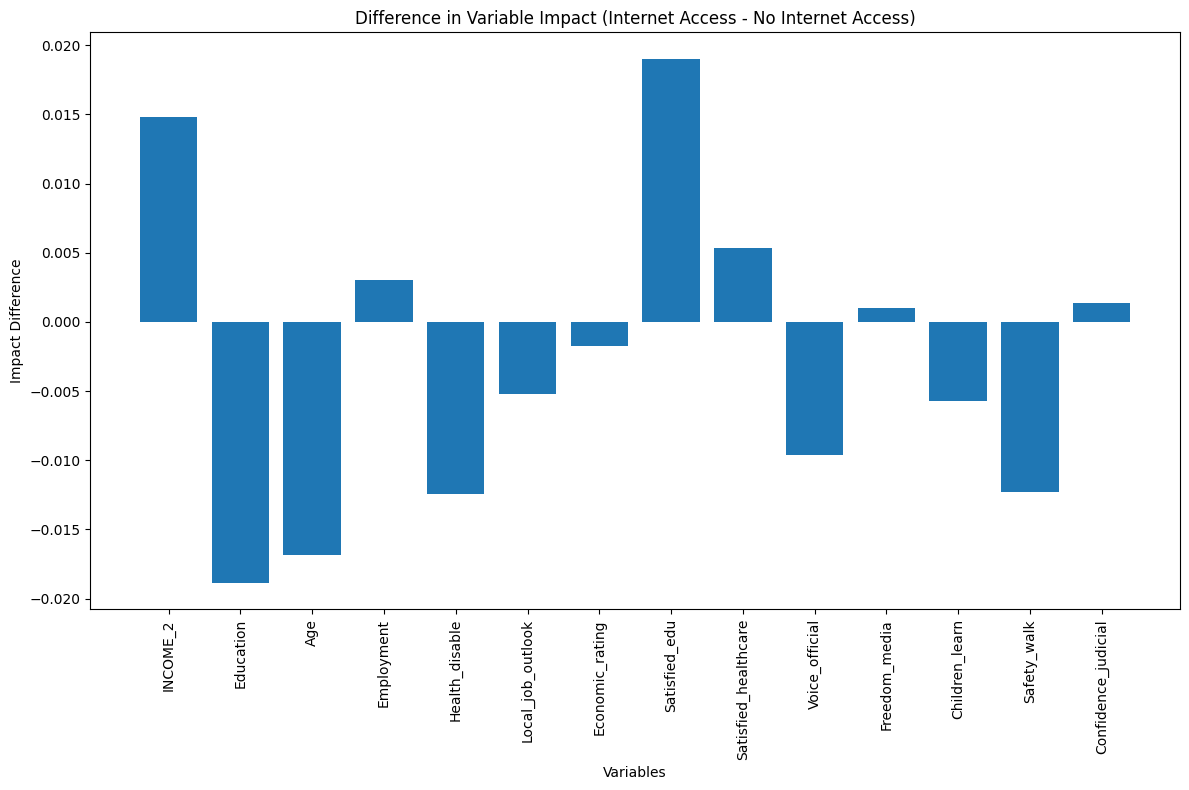

In [74]:
differences = []
for var in variables_of_interest:
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(var)]).mean()
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(var)]).mean()
    differences.append(impact_with - impact_without)

plt.figure(figsize=(12, 8))
plt.bar(variables_of_interest, differences)
plt.xticks(rotation=90)
plt.title("Difference in Variable Impact (Internet Access - No Internet Access)")
plt.xlabel("Variables")
plt.ylabel("Impact Difference")
plt.tight_layout()
plt.show()

### 12. The impact of Internet access

#### Estimating the overall impact of Internet access

In [97]:
internet_group = matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']
no_internet_group = matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder']

t_stat, p_value = stats.ttest_ind(internet_group, no_internet_group)

In [98]:
print(f"Internet Access Effect:")
print(f"Mean Cantril ladder score (with internet): {internet_group.mean():.4f}")
print(f"Mean Cantril ladder score (without internet): {no_internet_group.mean():.4f}")
print(f"Difference: {internet_group.mean() - no_internet_group.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Internet Access Effect:
Mean Cantril ladder score (with internet): 5.2581
Mean Cantril ladder score (without internet): 5.0167
Difference: 0.2413
T-statistic: 21.3597
P-value: 0.0000


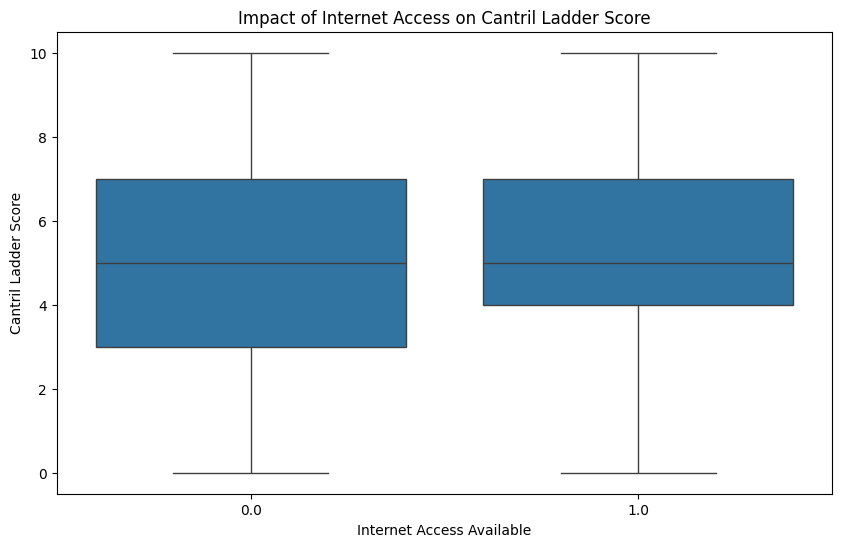

In [99]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Internet_access_available', y='Cantril_ladder', data=matched_df)
plt.title('Impact of Internet Access on Cantril Ladder Score')
plt.xlabel('Internet Access Available')
plt.ylabel('Cantril Ladder Score')
plt.show()

#### Average Cantril Ladder Score by Country

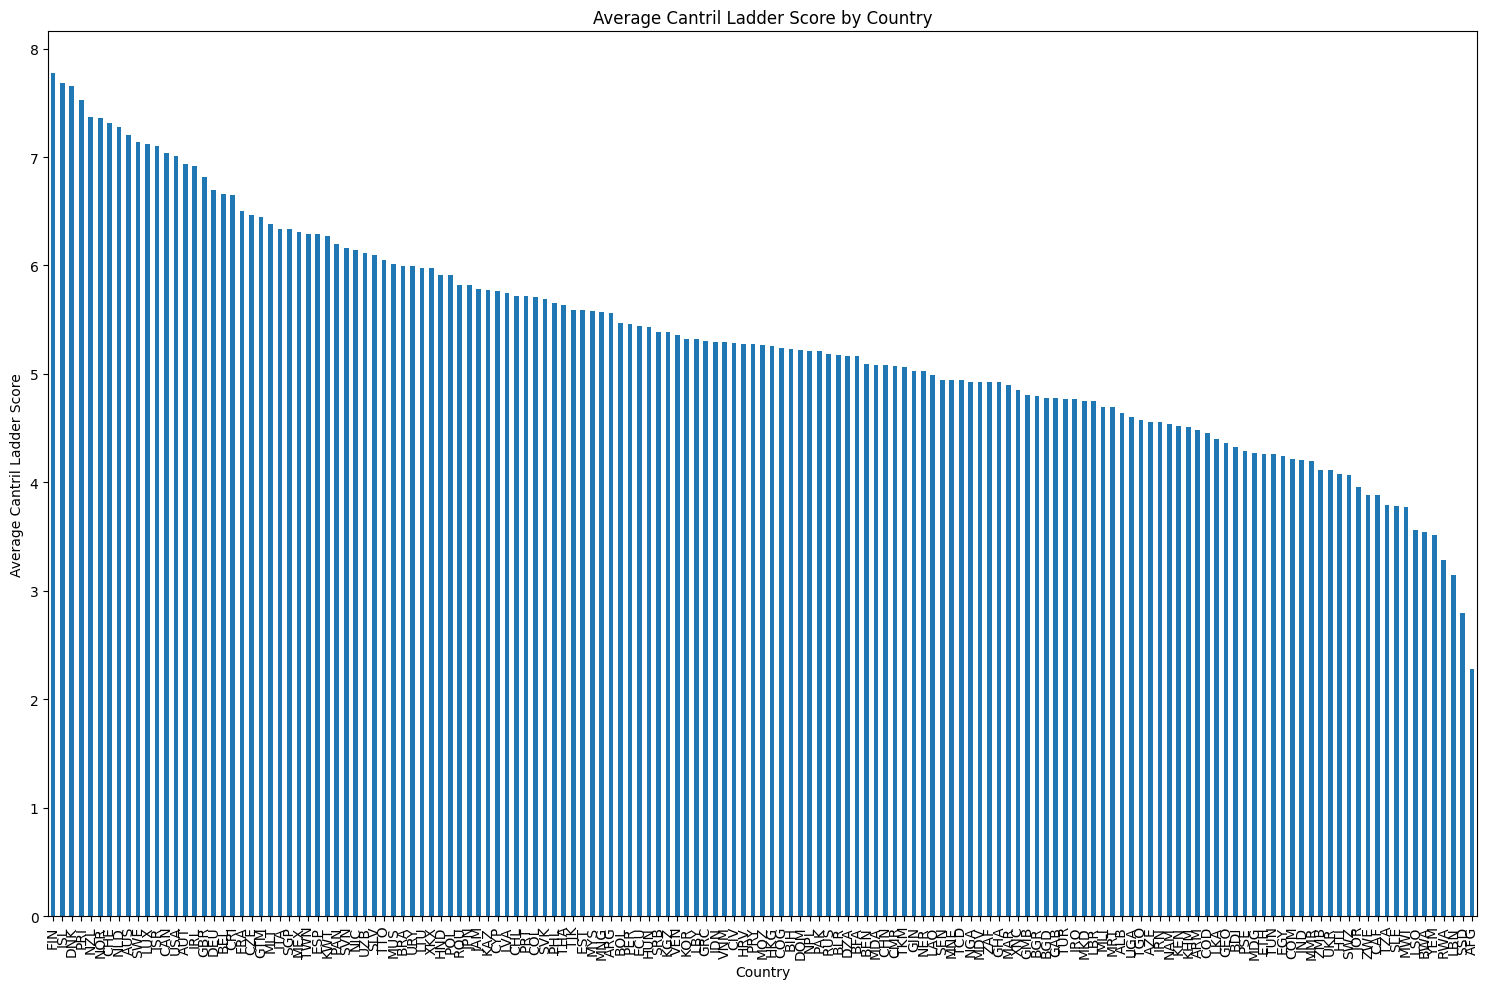


Top 10 countries with highest Cantril ladder scores:
FIN    7.770325
ISL    7.681250
DNK    7.655556
PRI    7.525547
NZL    7.365269
NOR    7.359788
CHE    7.309028
NLD    7.280665
AUS    7.204694
SWE    7.138716
dtype: float64

Bottom 10 countries with lowest Cantril ladder scores:
TZA    3.790676
SLE    3.777568
MWI    3.770806
LSO    3.560071
BWA    3.537343
YEM    3.510553
RWA    3.287599
LBN    3.141686
SSD    2.797048
AFG    2.278526
dtype: float64


In [101]:
# Step 3: Analyze the effect of different countries
country_columns = [col for col in matched_df.columns if col.startswith('COUNTRY_ISO3_')]
country_effects = {}

for country in country_columns:
    country_data = matched_df[matched_df[country] == 1]
    if len(country_data) > 0:
        country_effects[country.replace('COUNTRY_ISO3_', '')] = country_data['Cantril_ladder'].mean()

country_effects = pd.Series(country_effects).sort_values(ascending=False)

plt.figure(figsize=(15, 10))
country_effects.plot(kind='bar')
plt.title('Average Cantril Ladder Score by Country')
plt.xlabel('Country')
plt.ylabel('Average Cantril Ladder Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print("\nTop 10 countries with highest Cantril ladder scores:")
print(country_effects.head(10))
print("\nBottom 10 countries with lowest Cantril ladder scores:")
print(country_effects.tail(10))


#### The impact of internet access on Cantril ladder scores (by wave)

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
print(Df_new.columns.tolist())

In [82]:
# 步骤1：按波次计算效应
effects_by_wave = matched_df.groupby('wave').apply(lambda x: 
    pd.Series({
        'effect': np.mean(x[x['Internet_access_available'] == 1]['Cantril_ladder']) - 
                  np.mean(x[x['Internet_access_available'] == 0]['Cantril_ladder']),
        'count': len(x)
    })
).reset_index()
effects_by_wave = effects_by_wave.sort_values('wave')

print("按波次的效应：")
print(effects_by_wave)

按波次的效应：
   wave    effect    count
0    12  0.308694  40549.0
1    13  0.199387  42266.0
2    14  0.234663  48658.0
3    15  0.305411  25226.0
4    16  0.265782  27705.0
5    17  0.165983  35426.0


/tmp/ipykernel_2882936/1412594532.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  effects_by_wave = matched_df.groupby('wave').apply(lambda x:


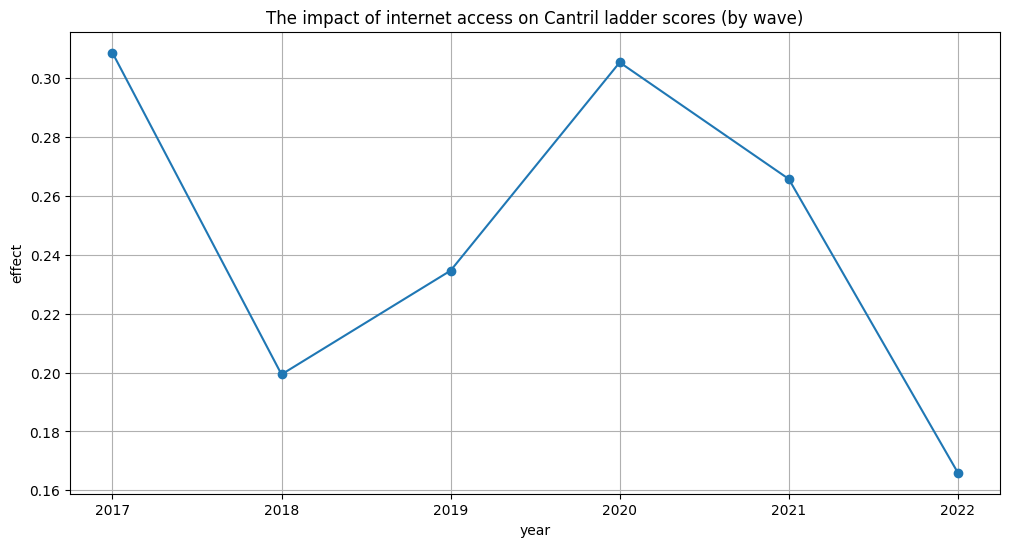

In [126]:
# 步骤3：可视化波次效应
plt.figure(figsize=(12, 6))
effects_by_wave['year'] = effects_by_wave['wave'] + 2005
plt.plot(effects_by_wave['year'], effects_by_wave['effect'], marker='o')
plt.title('The impact of internet access on Cantril ladder scores (by wave)')
plt.xlabel('year')
plt.ylabel('effect')
plt.grid(True)
plt.show()


#### Internet Effect on Cantril Ladder （by Country and Year）

In [104]:
# 获取所有国家列
country_columns = [col for col in matched_df.columns if col.startswith('COUNTRY_ISO3_')]

# 初始化结果列表
results = []

# 第2步: 对每个国家进行循环和计算
for country in country_columns:
    country_data = matched_df[matched_df[country] == 1]
    if len(country_data) > 0:  # 确保该国家有数据
        for wave in country_data['wave'].unique():
            wave_data = country_data[country_data['wave'] == wave]
            internet_effect = np.mean(wave_data[wave_data['Internet_access_available'] == 1]['Cantril_ladder']) - \
                              np.mean(wave_data[wave_data['Internet_access_available'] == 0]['Cantril_ladder'])
            results.append({
                'country': country.replace('COUNTRY_ISO3_', ''),
                'wave': wave,
                'internet_effect': internet_effect,
                'sample_size': len(wave_data)
            })

# 将结果转换为DataFrame
all_results = pd.DataFrame(results)

In [129]:
# 打印前几行结果以检查
print(all_results)

    country  wave  internet_effect  sample_size  year
0       AFG    13          -0.0347          251  2018
1       AFG    17           0.6335          276  2022
2       AFG    16           0.2332          305  2021
3       AFG    12           0.2167          249  2017
4       AFG    14           0.7864          330  2019
5       ALB    14          -0.2808          455  2019
6       ALB    13           0.2560          390  2018
7       ALB    16          -0.0556          438  2021
8       ALB    17          -0.1059          385  2022
9       ALB    12          -0.3653          355  2017
10      ALB    15           0.1490          258  2020
11      ARG    15           0.0965          148  2020
12      ARG    13           0.0970          330  2018
13      ARG    17           0.4099          243  2022
14      ARG    12           0.2423          360  2017
15      ARG    14           0.3724          280  2019
16      ARG    16           0.6229          131  2021
17      ARM    17           

In [132]:
# 指定需要的wave
required_waves = [12, 13, 14, 15, 16, 17]

# 创建一个数据透视表来检查每个国家在每个wave中是否有数据
wave_check = all_results.pivot_table(values='sample_size', index='country', columns='wave', aggfunc='size')

# 找出在所有required_waves中都有数据的国家
countries_with_all_waves = wave_check[wave_check[required_waves].notna().all(axis=1)].index

# 创建新的DataFrame，只包含这些国家的数据
new_results = all_results[all_results['country'].isin(countries_with_all_waves)]

# 进一步筛选，只保留required_waves的数据
new_results = new_results[new_results['wave'].isin(required_waves)]

# 找出被删除的国家
deleted_countries = set(all_results['country']) - set(countries_with_all_waves)


In [133]:
# 打印被删除的国家
print("删除的国家:")
for country in sorted(deleted_countries):
    print(country)

删除的国家:
AFG
ARM
AZE
BDI
BFA
BLR
BWA
CAF
CHN
COD
COM
CZE
ETH
GMB
GTM
HKG
HND
HTI
IRN
IRQ
ISL
JAM
KWT
LBN
LBR
LBY
LSO
LUX
MDA
MDG
MDV
MNE
MOZ
MRT
MWI
MYS
NER
PAN
PRI
PSE
RWA
SGP
SLE
SSD
SWZ
TCD
TGO
TKM
TTO
VEN
XNC
YEM
ZWE


In [135]:
# 打印新DataFrame的前几行
print("\nNew DataFrame head:")
print(new_results.head())


New DataFrame head:
  country  wave  internet_effect  sample_size  year
5     ALB    14          -0.2808          455  2019
6     ALB    13           0.2560          390  2018
7     ALB    16          -0.0556          438  2021
8     ALB    17          -0.1059          385  2022
9     ALB    12          -0.3653          355  2017


In [136]:
# 检查每个国家是否都有6个wave的数据
country_wave_counts = new_results.groupby('country')['wave'].nunique()
if (country_wave_counts == 6).all():
    print("\n所有保留的国家都有6个wave的数据。")
else:
    print("\n警告：某些国家没有6个wave的完整数据。")
    print(country_wave_counts[country_wave_counts != 6])


所有保留的国家都有6个wave的数据。


In [150]:
print(new_results)

    country  wave  internet_effect  sample_size  year
5       ALB    14          -0.2808          455  2019
6       ALB    13           0.2560          390  2018
7       ALB    16          -0.0556          438  2021
8       ALB    17          -0.1059          385  2022
9       ALB    12          -0.3653          355  2017
10      ALB    15           0.1490          258  2020
11      ARG    15           0.0965          148  2020
12      ARG    13           0.0970          330  2018
13      ARG    17           0.4099          243  2022
14      ARG    12           0.2423          360  2017
15      ARG    14           0.3724          280  2019
16      ARG    16           0.6229          131  2021
22      AUS    13          -0.4478          140  2018
23      AUS    17           0.0295           99  2022
24      AUS    15           0.0706          125  2020
25      AUS    14           0.8116          142  2019
26      AUS    12           0.1157          142  2017
27      AUS    16          -

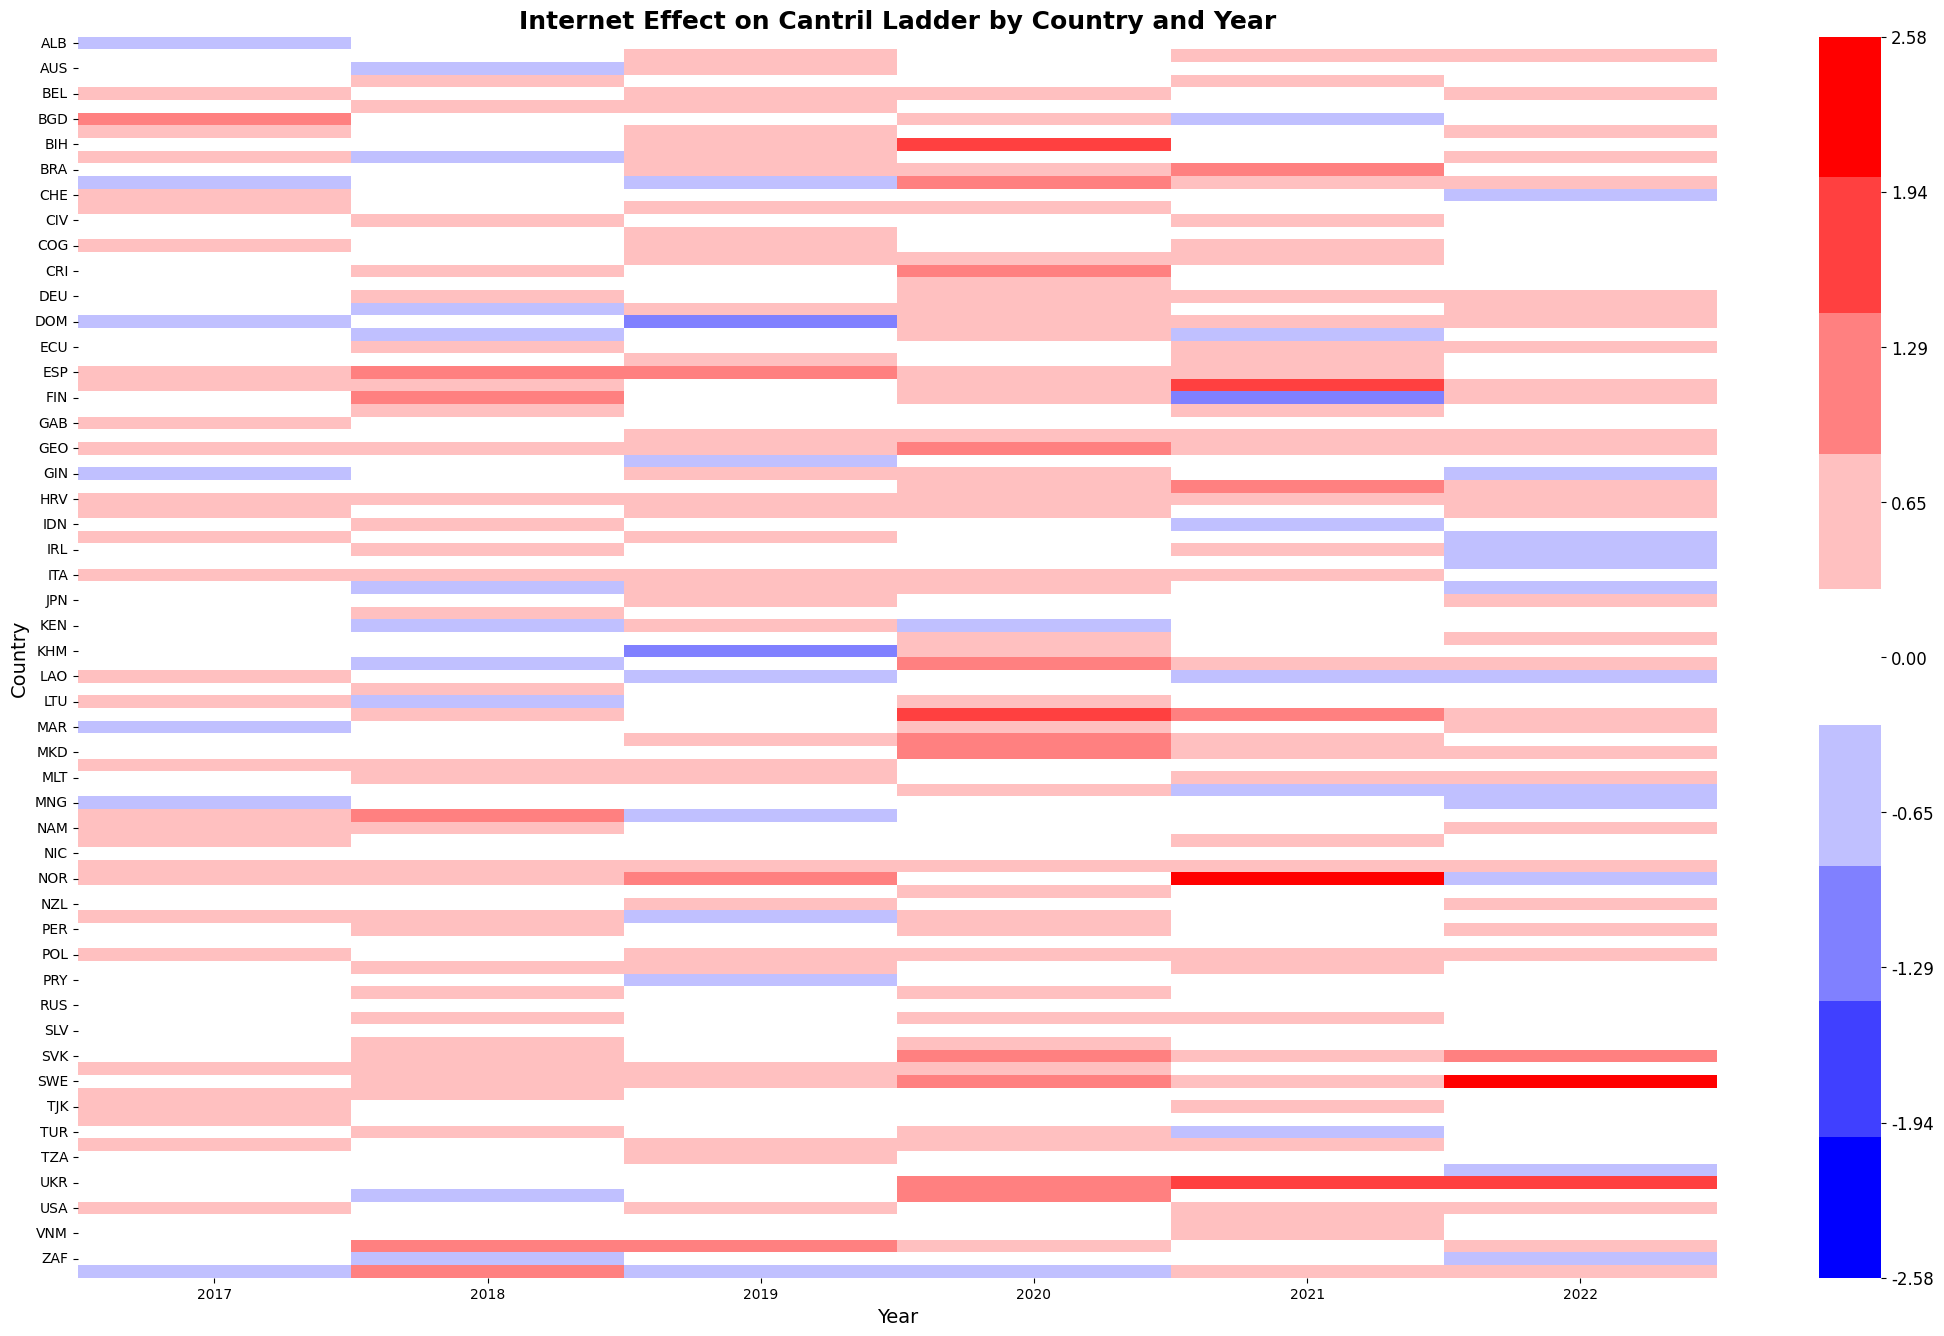

In [173]:
# 调整 wave 列，加上 2005
new_results['year'] = new_results['wave'] + 2005

# 计算颜色范围
vmin = new_results['internet_effect'].min()
vmax = new_results['internet_effect'].max()

# 创建对称的颜色范围
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

# 创建自定义的高对比度颜色映射
colors = ['#0000FF', '#4040FF', '#8080FF', '#C0C0FF', 'white', '#FFC0C0', '#FF8080', '#FF4040', '#FF0000']
n_bins = len(colors)
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# 创建热图
plt.figure(figsize=(22, 14))
heatmap_data = new_results.pivot(index='country', columns='year', values='internet_effect')

# 创建热图，设置颜色范围和分级数量
sns.heatmap(heatmap_data, 
            cmap=cmap, 
            center=0, 
            vmin=vmin, 
            vmax=vmax, 
            annot=False,
            cbar_kws={'ticks': np.linspace(vmin, vmax, 9)})

plt.title('Internet Effect on Cantril Ladder by Country and Year', fontsize=18, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Country', fontsize=14)

# 调整颜色条的标签
cbar = plt.gcf().axes[-1]
cbar.set_yticklabels([f'{x:.2f}' for x in cbar.get_yticks()], fontsize=12)

# 增加图表的整体大小和边距
plt.tight_layout(pad=3.0)

# 显示图表
plt.show()


#### Developed and developing countries

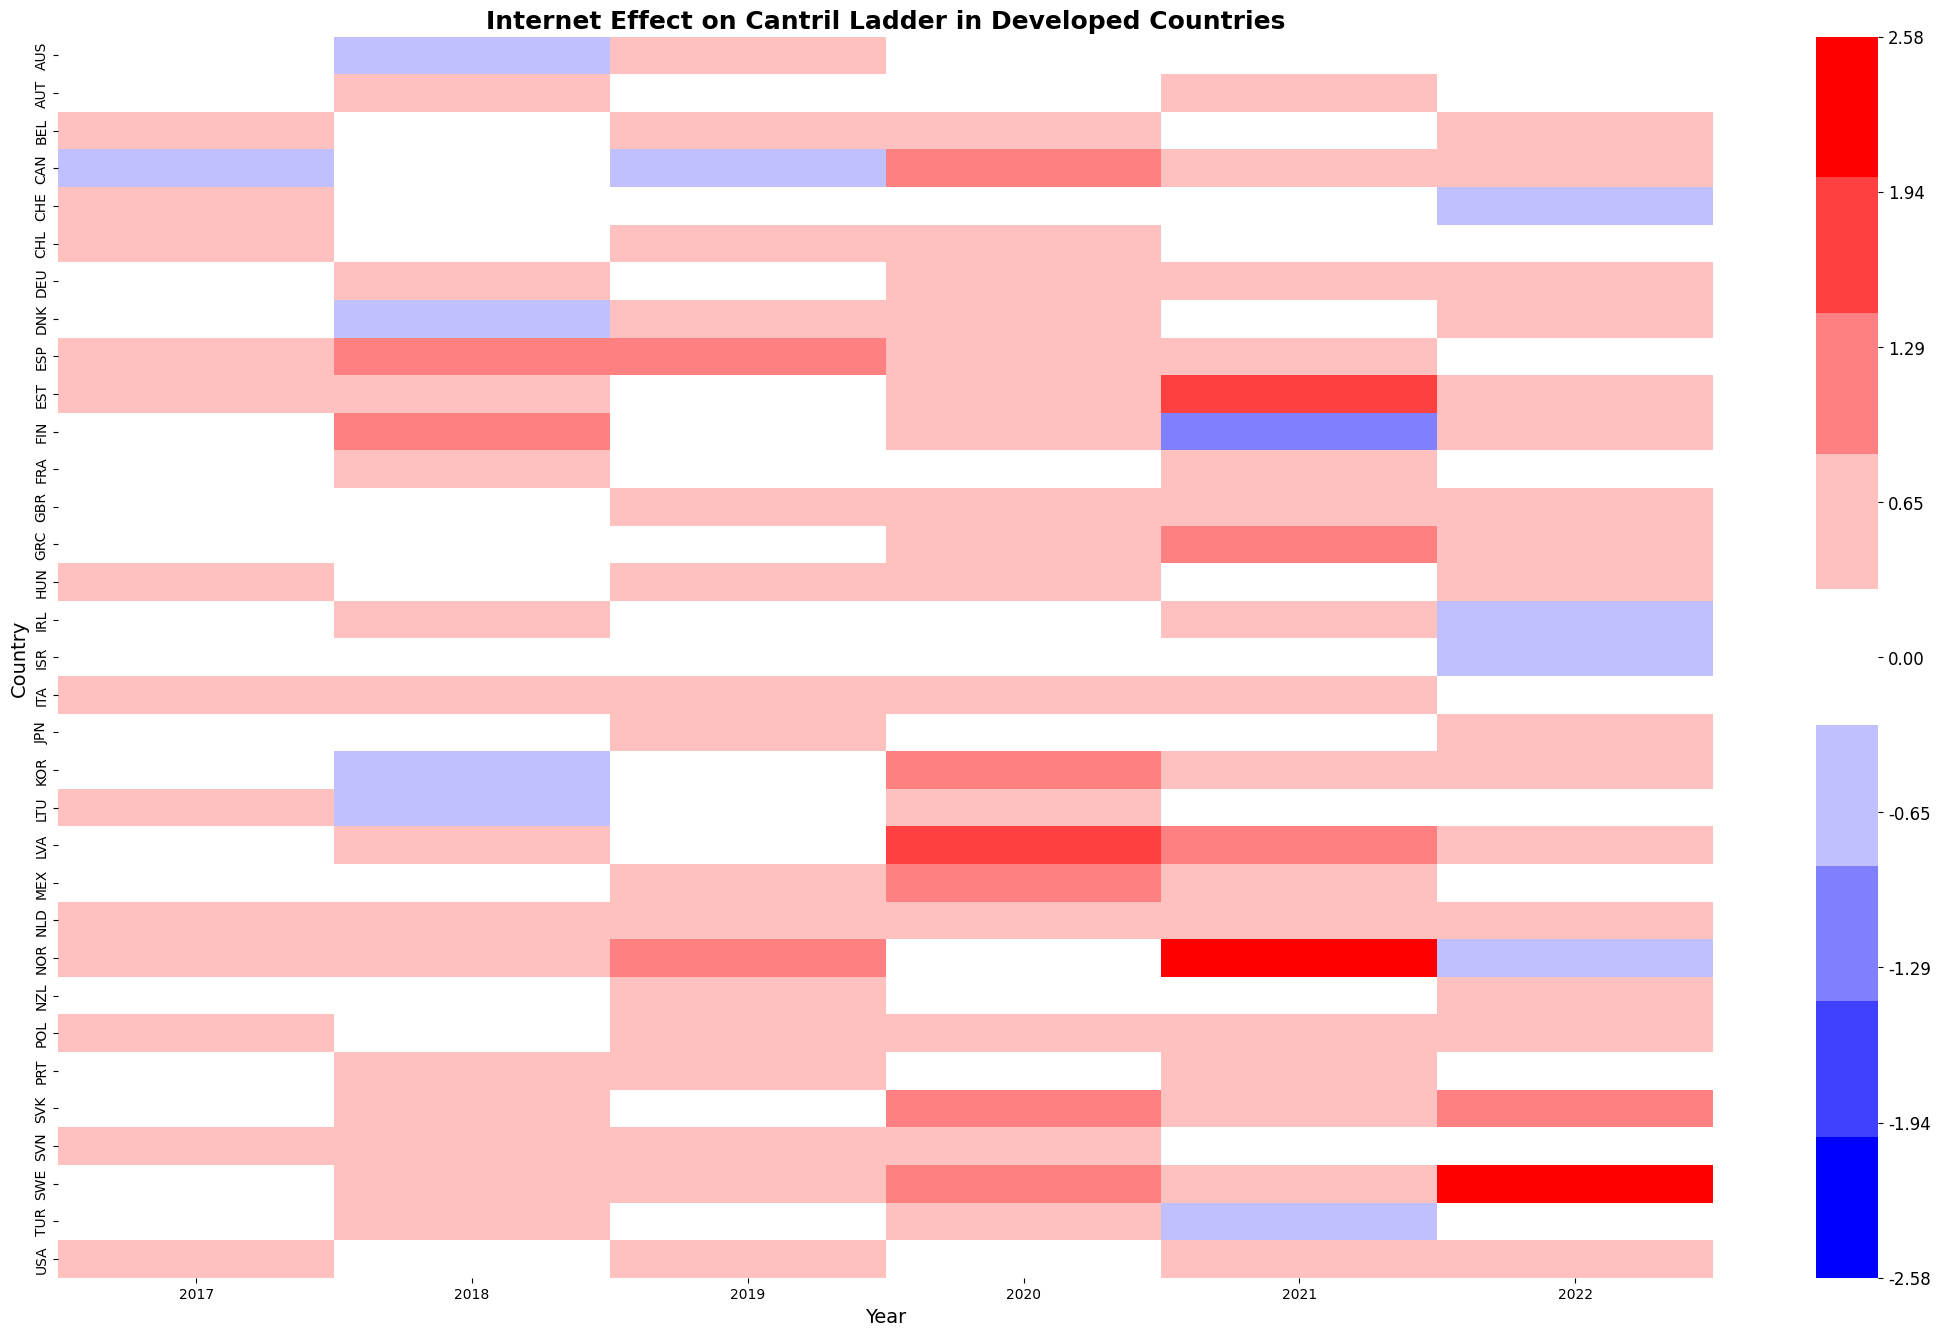

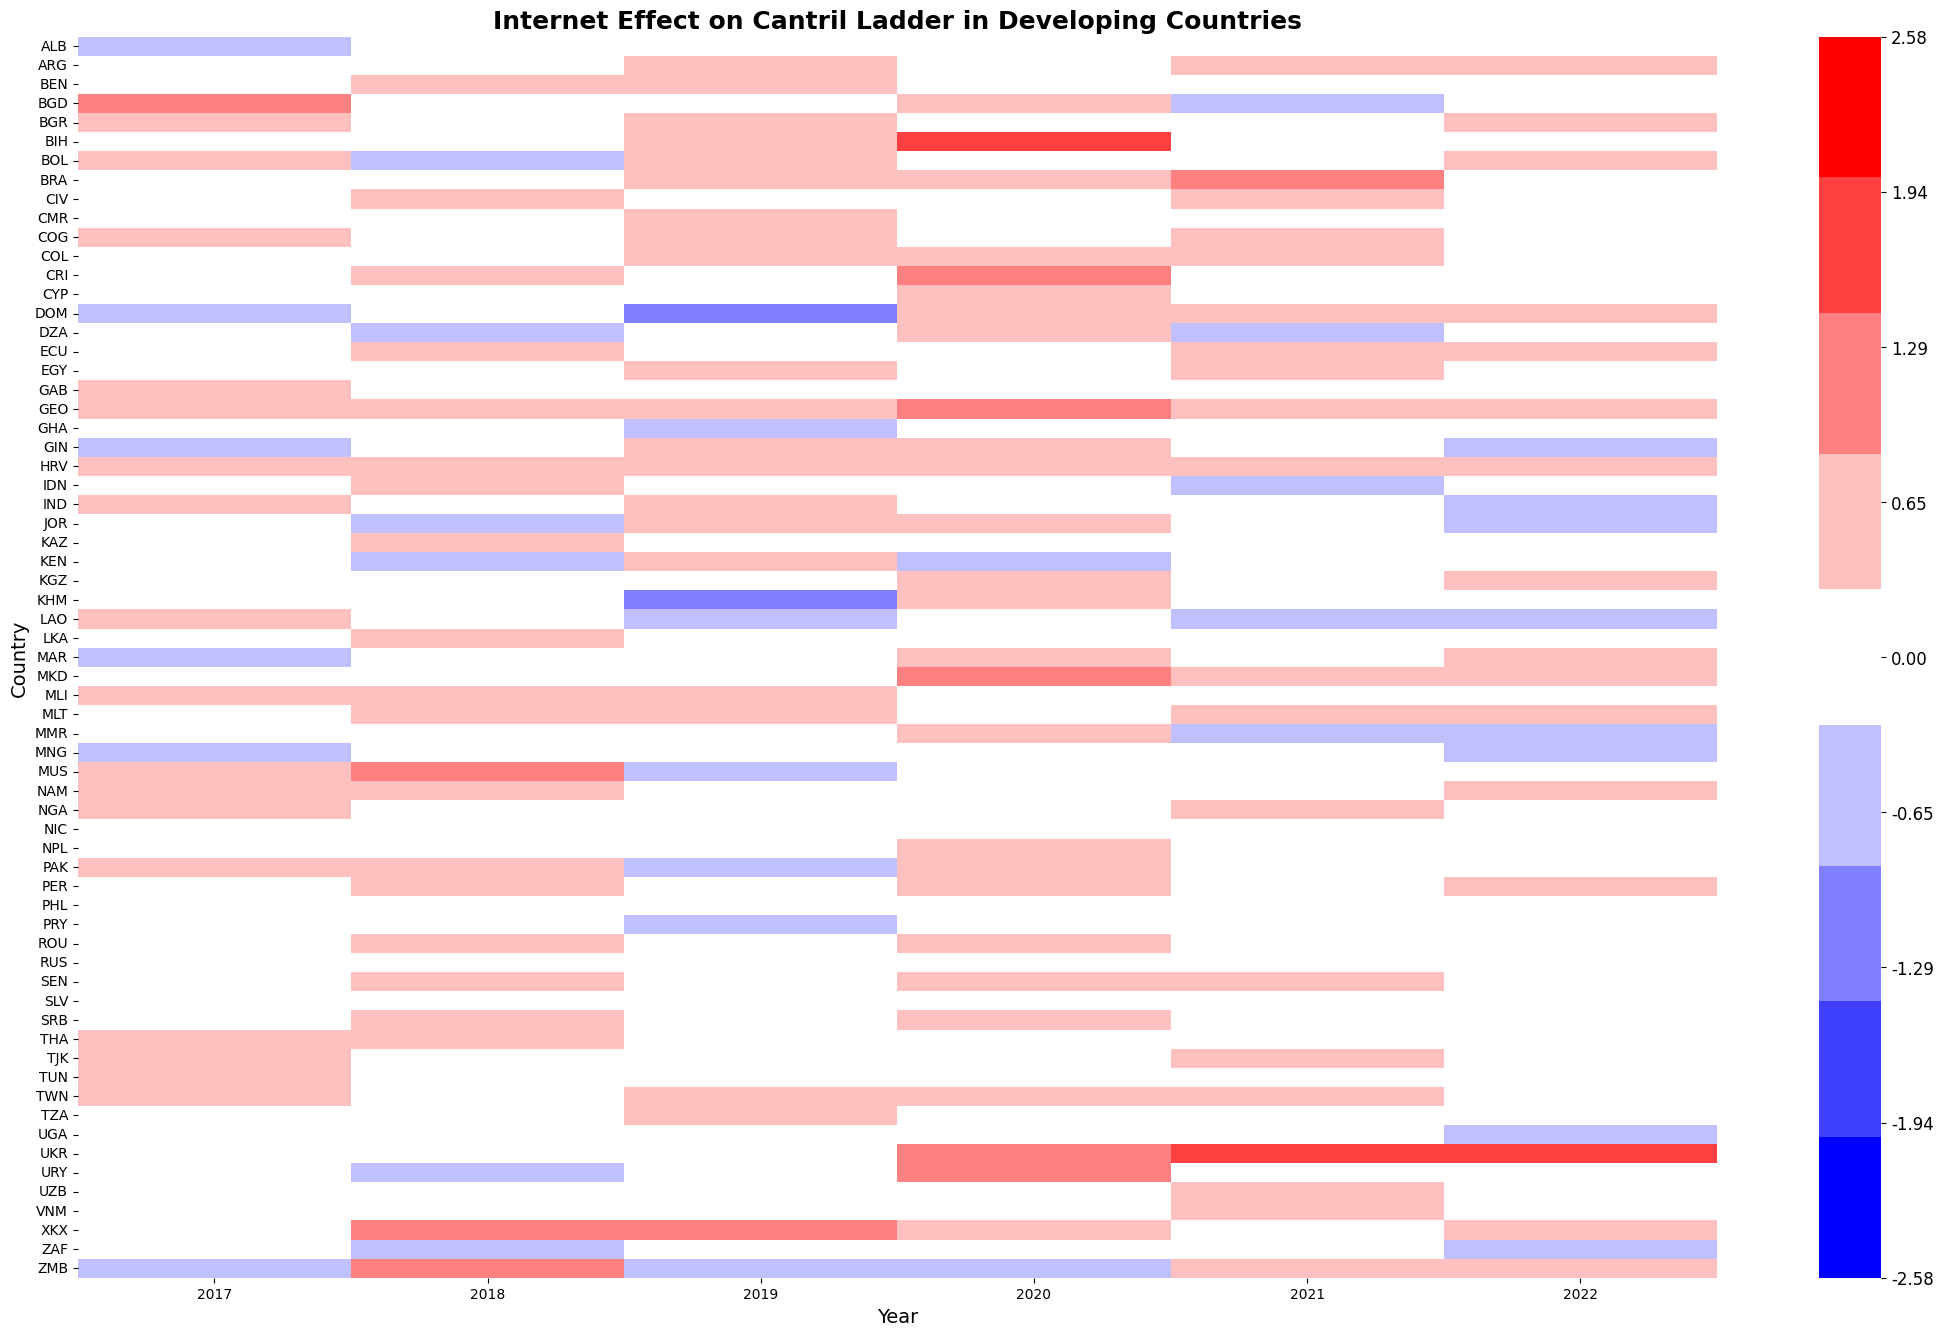

In [183]:
# 定义发达国家列表
developed_countries = ['AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 'KOR', 'LVA', 'LTU', 'LUX', 'MEX', 'NLD', 'NZL', 'NOR', 'POL', 'PRT', 'SVK', 'SVN', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'USA']

# 添加 'year' 列并分离发达国家和发展中国家的数据
new_results['year'] = new_results['wave'] + 2005
developed_data = new_results[new_results['country'].isin(developed_countries)]
developing_data = new_results[~new_results['country'].isin(developed_countries)]

# 计算整体的颜色范围
vmin = new_results['internet_effect'].min()
vmax = new_results['internet_effect'].max()
abs_max = max(abs(vmin), abs(vmax))
vmin, vmax = -abs_max, abs_max

# 创建自定义的高对比度颜色映射
colors = ['#0000FF', '#4040FF', '#8080FF', '#C0C0FF', 'white', '#FFC0C0', '#FF8080', '#FF4040', '#FF0000']
n_bins = len(colors)
cmap = LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# 创建热图的函数
def create_heatmap(data, title):
    plt.figure(figsize=(22, 14))
    heatmap_data = data.pivot(index='country', columns='year', values='internet_effect')
    
    sns.heatmap(heatmap_data, 
                cmap=cmap, 
                center=0, 
                vmin=vmin, 
                vmax=vmax, 
                annot=False,
                cbar_kws={'ticks': np.linspace(vmin, vmax, 9)})
    
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Country', fontsize=14)
    
    # 调整颜色条的标签
    cbar = plt.gcf().axes[-1]
    cbar.set_yticklabels([f'{x:.2f}' for x in cbar.get_yticks()], fontsize=12)
    
    # 增加图表的整体大小和边距
    plt.tight_layout(pad=3.0)
    plt.show()

# 创建发达国家的热图
create_heatmap(developed_data, 'Internet Effect on Cantril Ladder in Developed Countries')

# 创建发展中国家的热图
create_heatmap(developing_data, 'Internet Effect on Cantril Ladder in Developing Countries')


/tmp/ipykernel_2882936/3305044780.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  developed_data = new_results[all_results['country'].isin(developed_countries)]
/tmp/ipykernel_2882936/3305044780.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  developing_data = new_results[~all_results['country'].isin(developed_countries)]


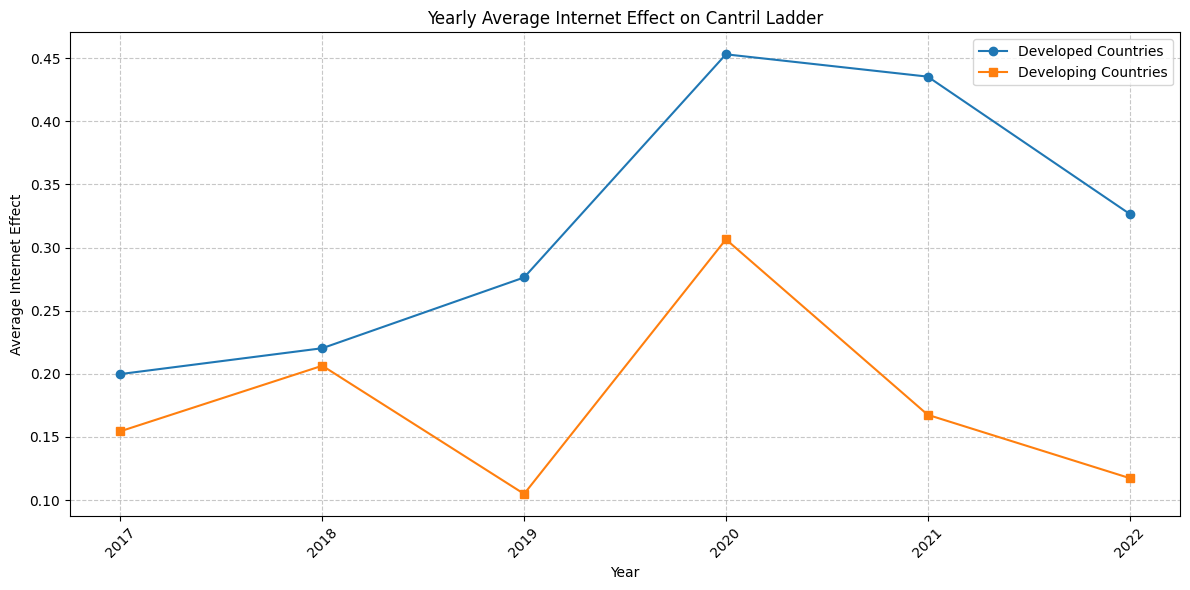

In [184]:
# 分离发达国家和发展中国家的数据
developed_data = new_results[all_results['country'].isin(developed_countries)]
developing_data = new_results[~all_results['country'].isin(developed_countries)]

# 计算每年的平均影响
yearly_effect_developed = developed_data.groupby('year')['internet_effect'].mean()
yearly_effect_developing = developing_data.groupby('year')['internet_effect'].mean()

# 创建折线图
plt.figure(figsize=(12, 6))
plt.plot(yearly_effect_developed.index, yearly_effect_developed.values, label='Developed Countries', marker='o')
plt.plot(yearly_effect_developing.index, yearly_effect_developing.values, label='Developing Countries', marker='s')

plt.title('Yearly Average Internet Effect on Cantril Ladder')
plt.xlabel('Year')
plt.ylabel('Average Internet Effect')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# 设置x轴刻度为每年
plt.xticks(yearly_effect_developed.index)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [185]:
# 打印每年的效果值
print("Yearly Average Internet Effect:")
print("\nDeveloped Countries:")
print(yearly_effect_developed)
print("\nDeveloping Countries:")
print(yearly_effect_developing)

Yearly Average Internet Effect:

Developed Countries:
year
2017   0.1998
2018   0.2203
2019   0.2764
2020   0.4531
2021   0.4354
2022   0.3267
Name: internet_effect, dtype: float64

Developing Countries:
year
2017   0.1545
2018   0.2064
2019   0.1049
2020   0.3065
2021   0.1676
2022   0.1175
Name: internet_effect, dtype: float64


In [186]:
# 计算总体平均效果
overall_effect_developed = developed_data['internet_effect'].mean()
overall_effect_developing = developing_data['internet_effect'].mean()

print(f"\nOverall average effect for developed countries: {overall_effect_developed:.4f}")
print(f"Overall average effect for developing countries: {overall_effect_developing:.4f}")


Overall average effect for developed countries: 0.3186
Overall average effect for developing countries: 0.1762


In [187]:
t_stat, p_value = stats.ttest_ind(developed_data['internet_effect'], developing_data['internet_effect'])

print(f"\nt-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")


t-statistic: 4.0937
p-value: 0.0000


#### Top 10 Countries with Positive Internet Effect on Cantril Ladder

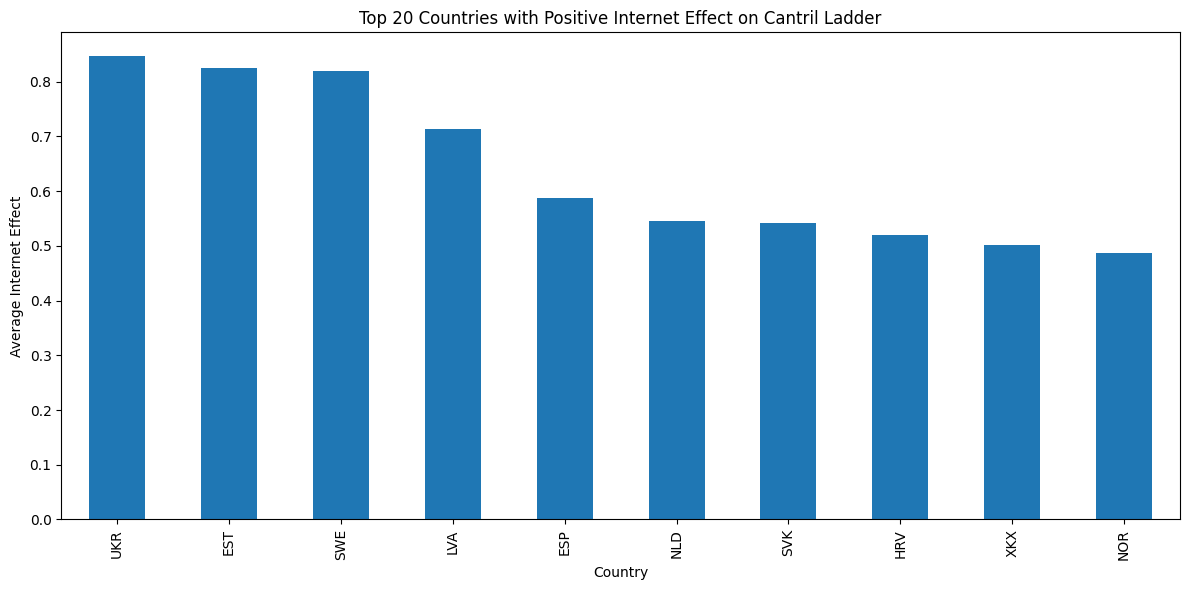

In [149]:
# 第4步: 分析正面影响最大的国家
top_10_positive = new_results.groupby('country')['internet_effect'].mean().nlargest(10)
plt.figure(figsize=(12, 6))
top_10_positive.plot(kind='bar')
plt.title('Top 20 Countries with Positive Internet Effect on Cantril Ladder')
plt.xlabel('Country')
plt.ylabel('Average Internet Effect')
plt.tight_layout()
plt.show()

##### Ukraine

Comparison of Cantril ladder scores for Ukraine (UKR) in different years：
 year  internet  no_internet  difference
 2017    3.7842       3.6894      0.0948
 2018    4.1860       3.9310      0.2550
 2019    4.2876       4.0675      0.2201
 2020    4.9773       4.0857      0.8916
 2021    5.2182       3.5484      1.6698
 2022    4.7544       2.8000      1.9544


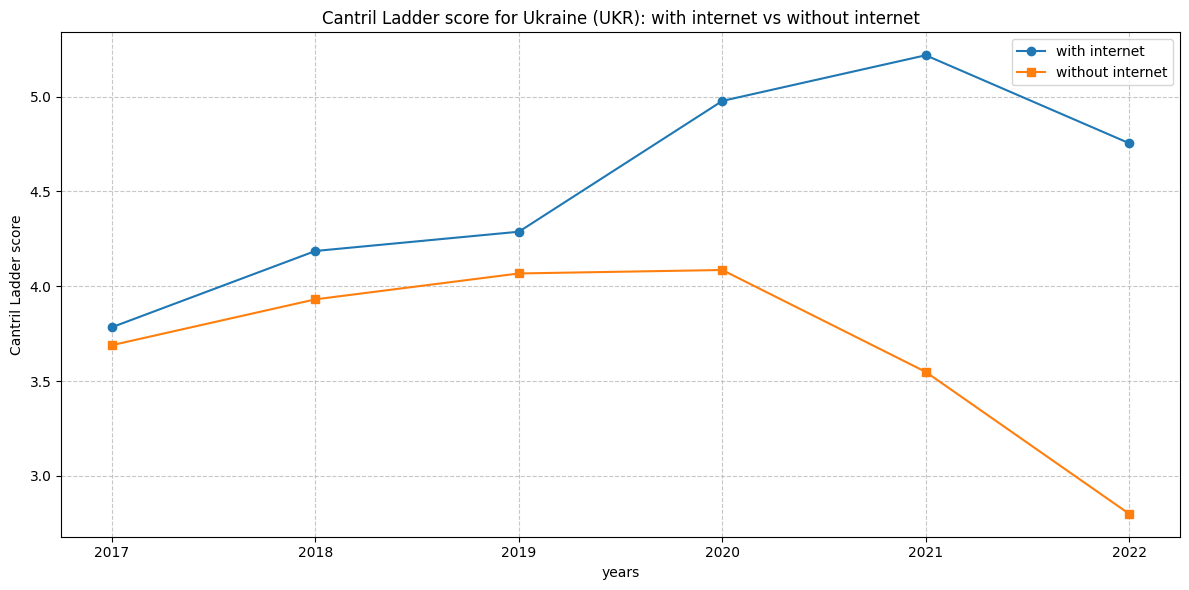


在所有年份中，有互联网的平均 Cantril ladder 分数比无互联网高 0.8476 分

配对 t 检验结果：
t 统计量：2.5894
p 值：0.0489
差异在统计上是显著的 (p < 0.05)


In [167]:
# 确保 UKR 在 new_results 中
if 'UKR' not in new_results['country'].unique():
    print("UKR 不在 new_results 数据集中。可能是因为它没有所有required waves的数据。")
else:
    # 从 new_results 中提取 UKR 的数据
    ukr_data = new_results[new_results['country'] == 'UKR']

    # 从原始的 matched_df 中获取 UKR 的详细数据
    ukr_full_data = matched_df[matched_df['COUNTRY_ISO3_UKR'] == 1]

    # 创建一个结果列表来存储每个 year 的数据
    ukr_results = []

    for wave in [12, 13, 14, 15, 16, 17]:
        year = wave + 2005  # 将 wave 转换为年份
        wave_data = ukr_full_data[ukr_full_data['wave'] == wave]
        
        internet_score = wave_data[wave_data['Internet_access_available'] == 1]['Cantril_ladder'].mean()
        no_internet_score = wave_data[wave_data['Internet_access_available'] == 0]['Cantril_ladder'].mean()
        
        ukr_results.append({
            'year': year,
            'internet': internet_score,
            'no_internet': no_internet_score,
            'difference': internet_score - no_internet_score
        })

    # 将结果转换为 DataFrame
    ukr_results_df = pd.DataFrame(ukr_results)

    # 打印结果
    print("Comparison of Cantril ladder scores for Ukraine (UKR) in different years：")
    print(ukr_results_df.to_string(index=False))

    # 创建可视化
    plt.figure(figsize=(12, 6))
    
    plt.plot(ukr_results_df['year'], ukr_results_df['internet'], marker='o', label='with internet')
    plt.plot(ukr_results_df['year'], ukr_results_df['no_internet'], marker='s', label='without internet')

    plt.title('Cantril Ladder score for Ukraine (UKR): with internet vs without internet')
    plt.xlabel('years')
    plt.ylabel('Cantril Ladder score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # 设置 x 轴刻度为实际年份
    plt.xticks(ukr_results_df['year'])

    plt.tight_layout()
    plt.show()

    # 计算并打印平均差异
    avg_difference = ukr_results_df['difference'].mean()
    print(f"\n在所有年份中，有互联网的平均 Cantril ladder 分数比无互联网高 {avg_difference:.4f} 分")

    # 进行配对 t 检验
    from scipy import stats
    t_stat, p_value = stats.ttest_rel(ukr_results_df['internet'], ukr_results_df['no_internet'])
    print(f"\n配对 t 检验结果：")
    print(f"t 统计量：{t_stat:.4f}")
    print(f"p 值：{p_value:.4f}")
    if p_value < 0.05:
        print("差异在统计上是显著的 (p < 0.05)")
    else:
        print("差异在统计上不显著 (p >= 0.05)")

#### Top 10 Countries with Negative Internet Effect on Cantril Ladder

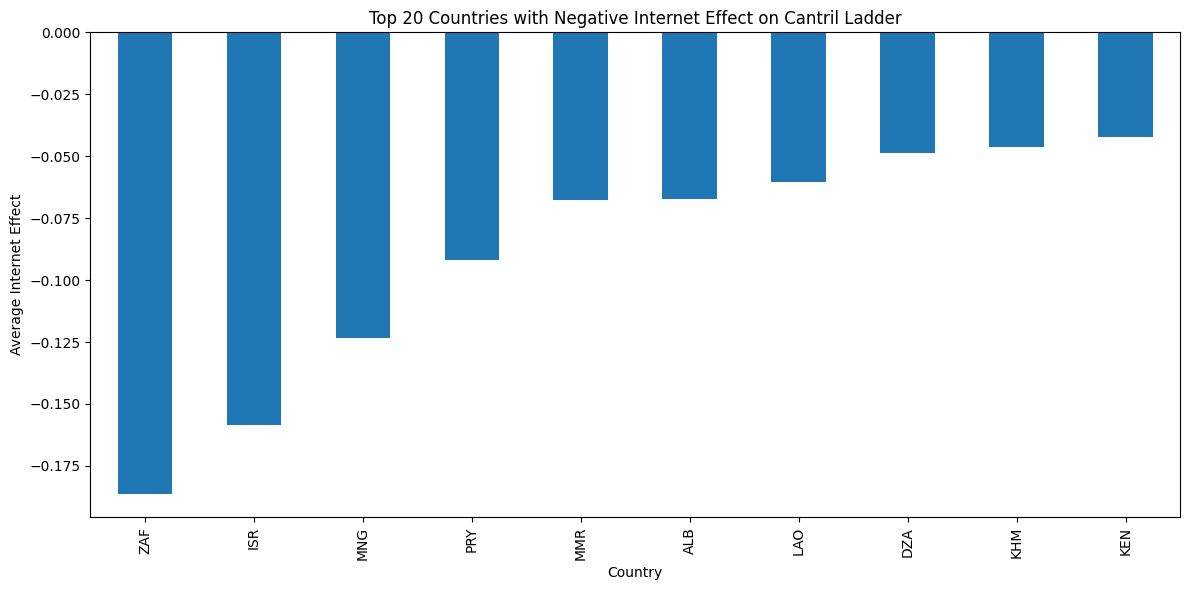

In [148]:
# 第5步: 分析负面影响最大的国家
top_10_negative = new_results.groupby('country')['internet_effect'].mean().nsmallest(10)
plt.figure(figsize=(12, 6))
top_10_negative.plot(kind='bar')
plt.title('Top 20 Countries with Negative Internet Effect on Cantril Ladder')
plt.xlabel('Country')
plt.ylabel('Average Internet Effect')
plt.tight_layout()
plt.show()

### 13.Significance Test

In [76]:
from statsmodels.stats.multitest import multipletests

In [77]:
def compare_variable_impact_with_significance(variable_name):
    impact_with = np.abs(shap_values_treated[:, X_test_treated.columns.get_loc(variable_name)])
    impact_without = np.abs(shap_values_control[:, X_test_control.columns.get_loc(variable_name)])
    
    mean_with = impact_with.mean()
    mean_without = impact_without.mean()
    
    t_stat, p_value = stats.ttest_ind(impact_with, impact_without)
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {mean_with:.4f}")
    print(f"  Without Internet Access: {mean_without:.4f}")
    print(f"  Difference: {mean_with - mean_without:.4f}")
    print(f"  T-statistic: {t_stat:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    return variable_name, p_value

variables_of_interest = [
    'INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 
    'Local_job_outlook', 'Economic_rating',
    'Satisfied_edu', 'Satisfied_healthcare', 'Voice_official', 'Freedom_media',
    'Children_learn', 'Safety_walk', 'Confidence_judicial'
]

# 进行所有变量的显著性测试
results = [compare_variable_impact_with_significance(var) for var in variables_of_interest]

# 使用Bonferroni校正进行多重比较调整
_, adjusted_p_values, _, _ = multipletests([r[1] for r in results], method='bonferroni')

print("\nAdjusted p-values after Bonferroni correction:")
for (var, _), adj_p in zip(results, adjusted_p_values):
    print(f"{var}: {adj_p:.4f}")

# 确定哪些差异在校正后仍然显著
significance_level = 0.05
significant_variables = [var for (var, _), adj_p in zip(results, adjusted_p_values) if adj_p < significance_level]

print("\nVariables with statistically significant differences after correction:")
for var in significant_variables:
    print(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2302
  Without Internet Access: 0.2155
  Difference: 0.0148
  T-statistic: 21.0610
  P-value: 0.0000
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0745
  Without Internet Access: 0.0933
  Difference: -0.0189
  T-statistic: -85.6713
  P-value: 0.0000
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0831
  Without Internet Access: 0.0999
  Difference: -0.0168
  T-statistic: -53.0466
  P-value: 0.0000
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0285
  Without Internet Access: 0.0254
  Difference: 0.0031
  T-statistic: 26.4386
  P-value: 0.0000
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0716
  Without Internet Access: 0.0841
  Difference: -0.0125
  T-statistic: -64.4054
  P-value: 0.0000
Impact of Local_job_outlook on Cantril_ladder:
  With Internet Access: 0.0446
  Without Internet Access: 0.0498
  Difference: -0.0052
  T-statistic: -64.5445
  P-val

In [79]:
pd.set_option('display.max_columns', None)

In [81]:
print(Df_new.columns.tolist())

['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have', 'Living_standard_trend', 'Enough_food', 'Enough_shelter', 'Well_rested', 'Respected', 'Interesting_thing', 'Physical_pain', 'City_satisfaction', 'Recommended_live_place', 'Economic_rating', 'Economic_trend', 'Local_job_outlook', 'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu', 'Satisfied_qualityair', 'Satisfied_qualitywater', 'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend', 'Good_minorities', 'Good_homo', 'Good_immigrants', 'Voice_official', 'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted', 'Children_learn', 'Satisfied_dealpoor', 'Satisfied_Env_preservation', 'Satisfied_Personalfreedom', 'Confidence_military', 'Confidence_judicial', 'Confidence_gov', 'Confidence_fin', 'Confidence_honestyelections', 'Freedom_media', 'Corruption_business', 'Corruption_government', 'Performance_leadership', 'Gender_female', 'Age', 'Education', 'Marital_status', 'Employment', 'Children_under

In [ ]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access', 'Life_satisfaction', 'Enjoyment', 'Smile', 'Worry', 'Sadness']
Df_new = Df_new.drop(columns=features_to_remove)

In [ ]:
# 2. 准备数据
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# 3. 优化随机森林参数
def optimize_rf_params(X_train, y_train):
    param_grid = {
        'n_estimators': [500],
        'max_depth': [10],
    
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_rf_params(X_train, y_train)

In [ ]:
# 4. 评估最佳模型
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

In [ ]:
# 5. 估算倾向得分
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

In [ ]:
# 6. 可视化倾向得分分布
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()


In [ ]:
sd_propensity = Df_new['propensity_score'].std()
recommended_caliper = 0.2 * sd_propensity
print(f"Recommended Caliper (0.2 * SD of propensity scores): {recommended_caliper:.4f}")

In [ ]:
from sklearn.neighbors import BallTree

In [ ]:
# 7. 多对一匹配
def match_samples_many_to_one_efficient(df, caliper=0.1, max_matches=3, n_jobs=-1, batch_size=12000):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    tree = BallTree(control[['propensity_score']], leaf_size=150)
    
    matched_pairs = []
    control_usage = {}

    for i in range(0, len(treated), batch_size):
        batch = treated.iloc[i:i+batch_size]
        indices = tree.query_radius(batch[['propensity_score']], r=caliper)
        
        for j, idx in enumerate(indices):
            for k in idx:
                if k not in control_usage or control_usage[k] < max_matches:
                    matched_pairs.append((i+j, k))
                    control_usage[k] = control_usage.get(k, 0) + 1
                    break

    matched_treated = treated.iloc[[pair[0] for pair in matched_pairs]]
    matched_control = control.iloc[[pair[1] for pair in matched_pairs]]
    
    matched_df = pd.concat([matched_treated, matched_control])

    print(f"Total matched pairs: {len(matched_pairs)}")
    print(f"Unique control samples used: {len(set(pair[1] for pair in matched_pairs))}")
    
    duplicate_counts = pd.Series(control_usage).value_counts().sort_index()
    print("\nDistribution of control sample usage:")
    print(duplicate_counts)

    plt.figure(figsize=(10, 6))
    plt.hist([matched_treated['propensity_score'], matched_control['propensity_score']], 
             label=['Treated', 'Control'], bins=50, alpha=0.5)
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Distribution of Propensity Scores After Matching')
    plt.legend()
    plt.show()

    return matched_df

matched_df = match_samples_many_to_one_efficient(Df_new)

In [ ]:
# 8. 平衡性检验
def calculate_smd(df, variables, treatment_col):
    means_treated = df[df[treatment_col] == 1][variables].mean()
    means_control = df[df[treatment_col] == 0][variables].mean()
    std_control = df[df[treatment_col] == 0][variables].std()
    smd = (means_treated - means_control) / std_control
    return smd

variables = [col for col in Df_new.columns if col not in ['propensity_score', 'Internet_access_available']]

smd_before = calculate_smd(Df_new, variables, 'Internet_access_available')
smd_after = calculate_smd(matched_df, variables, 'Internet_access_available')

smd_df = pd.DataFrame({
    'Variable': variables,
    'SMD Before': smd_before.values,
    'SMD After': smd_after.values
})
print(smd_df)

plt.figure(figsize=(10, 8))
plt.scatter(smd_df['SMD Before'], smd_df['Variable'], color='red', label='Before Matching')
plt.scatter(smd_df['SMD After'], smd_df['Variable'], color='blue', label='After Matching')
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel('Standardized Mean Differences (SMD)')
plt.ylabel('Variables')
plt.title('Comparison of SMD Before and After Matching')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 9. 分组分析
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']

    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device='cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test

model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)

In [ ]:
# 10. SHAP值分析
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()
